In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Configure data path
DATA_PATH = "/content/drive/My Drive/CS230 Stock Project/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Data Loading**

In [0]:
import os
import pandas as pd
import time

# Check if directory exist
# Path = 'D:\XDM Download\Compressed\ReutersNews106521\ReutersNews106521'
path="D:\XDM Download\Compressed\bloombergnews"
print(os.path.isdir(path))

# Helper function traverse directory contains news 
# Returns a interator 
def scanRec(baseDir):
    for entry in os.scandir(baseDir):
        if entry.is_file():
            yield entry.path
        elif entry.is_dir():
            yield from scanRec(entry.path)


# Store all file path in a list
files_path = []
for file_path in scanRec(path):
    files_path.append(file_path)


newsDF = pd.DataFrame(columns = ['title','time','content'])
# File operation
for file_path in files_path:
    # Tempt to read files line by line
    try:
        with open(file_path) as f:
            lines = [line.rstrip() for line in f]
        # Get the title of news
        newsTitle = lines[0][3:] 
        # Format time of the news
        dateTime = lines[2][3:]
        newsTime = time.strptime(dateTime[:-4], '%a %b %d, %Y %I:%M%p')
        # Dump the rest of the news in contents
        newsContent = lines[3:]
        # Store everything in a news dataframe
        newsDF = newsDF.append({'title' : newsTitle, 'time' : newsTime, 'content' : newsContent}, ignore_index=True)
    except Exception:
        print(file_path)


# **Open Information Extraction**

In [0]:
# Import libraries
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import time
import string

In [0]:
# Load bloomberg dataset
bloomberg = pd.read_pickle(DATA_PATH + "/bloombergTitleTime.pkl")
# Load reuters dataset
reuters = pd.read_pickle(DATA_PATH + "/reutersNewsTitleTimeOnly.pkl")

In [0]:
# Prepare Open IE
import stanfordnlp
nlp = stanfordnlp.Pipeline()

from openie import StanfordOpenIE

In [0]:
event_tuples = []

# Process titles from Reuters
with StanfordOpenIE() as client:
    for index, row in reuters.iterrows():
        text = row['title']
        #print(text)
        for triple in client.annotate(text):
            triple['time'] = row['time']
            event_tuples.append(triple)
            #print(triple)
        #print("=======================")

# Process titles from Bloomberg
with StanfordOpenIE() as client:
    for index, row in bloomberg.iterrows():
        text = row['title']
        #print(text)
        for triple in client.annotate(text):
            triple['time'] = row['time']
            event_tuples.append(triple)

In [0]:
# Save event tuples
event_tuples.to_pickle(DATA_PATH + "/event-tuples.pkl")

# **Prepare Data Labels**

In [0]:
# Load stock prices
SP500 = pd.read_csv(DATA_PATH + '/SP500.csv')
SP500.head

<bound method NDFrame.head of       Unnamed: 0    GSPC.Open  ...   GSPC.Volume  GSPC.Adjusted
0     2006-10-20  1366.939941  ...  2.526410e+09    1368.599976
1     2006-10-23  1368.579956  ...  2.480430e+09    1377.020020
2     2006-10-24  1377.020020  ...  2.876890e+09    1377.380005
3     2006-10-25  1377.359985  ...  2.953540e+09    1382.219971
4     2006-10-26  1382.209961  ...  2.793350e+09    1389.079956
...          ...          ...  ...           ...            ...
1783  2013-11-20  1789.589966  ...  3.109140e+09    1781.369995
1784  2013-11-21  1783.520020  ...  3.256630e+09    1795.849976
1785  2013-11-22  1797.209961  ...  3.055140e+09    1804.760010
1786  2013-11-25  1806.329956  ...  2.998540e+09    1802.479980
1787  2013-11-26  1802.869995  ...  3.427120e+09    1802.750000

[1788 rows x 7 columns]>

In [0]:
# Mark price increase as +1 and price decrease as 0
SP500_daily_return = SP500[['GSPC.Adjusted']].pct_change()
SP500_movement_direction = (SP500_daily_return > 0) * 1
#SP500_movement_direction[SP500_movement_direction == 0] = 0
# Add time information
SP500_movement_direction['time'] = SP500['Unnamed: 0']

In [0]:
SP500_movement_direction

GSPC.Adjusted        time
0                 0  2006-10-20
1                 1  2006-10-23
2                 1  2006-10-24
3                 1  2006-10-25
4                 1  2006-10-26
...             ...         ...
1783              0  2013-11-20
1784              1  2013-11-21
1785              1  2013-11-22
1786              0  2013-11-25
1787              1  2013-11-26

[1788 rows x 2 columns]

In [0]:
# Store SP500_movement_direction
SP500_movement_direction.to_pickle(DATA_PATH + "/SP500_movement_direction.pkl")

# **Word2Vec**

In [0]:
import numpy as np
import time
#import word2vec
import pickle
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
#loading word2vec model
import gensim.downloader as api
info = api.info()
model = api.load("word2vec-google-news-300")

# **Visualization of Embedding**

In [0]:
df = pd.read_pickle(DATA_PATH + "/wordEmbedingVecDF.pkl")

In [0]:
embeddingDF = df

In [0]:
df[:10]

object  ...                                   time
0  [0.0205078125, -0.3408203125, -0.291748046875,...  ...  (2006, 10, 20, 18, 15, 0, 4, 293, -1)
1  [0.271484375, 0.25390625, 0.05712890625, -0.02...  ...  (2006, 10, 22, 12, 14, 0, 6, 295, -1)
2  [0.30712890625, 0.313232421875, -0.21435546875...  ...  (2006, 10, 22, 12, 14, 0, 6, 295, -1)
3  [-0.26708984375, 0.0401611328125, 0.1710205078...  ...  (2006, 10, 21, 20, 11, 0, 5, 294, -1)
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...  (2006, 10, 21, 20, 11, 0, 5, 294, -1)
5  [0.11376953125, -0.11767578125, 0.06494140625,...  ...  (2006, 10, 21, 20, 11, 0, 5, 294, -1)
6  [0.1884765625, -0.0703125, -0.1611328125, 0.03...  ...   (2006, 10, 22, 6, 46, 0, 6, 295, -1)
7  [0.1884765625, -0.0703125, -0.1611328125, 0.03...  ...   (2006, 10, 22, 6, 46, 0, 6, 295, -1)
8  [0.0810546875, -0.2353515625, -0.0458984375, -...  ...  (2006, 10, 22, 20, 36, 0, 6, 295, -1)
9  [-0.034423828125, 0.2421875, -0.1259765625, -0...  ...   (2006, 10, 23, 1, 50, 0, 0, 296, -1)

[10 rows x 4 columns]

In [0]:
ieDF = pd.read_pickle(DATA_PATH + "/event-tuples.pkl")

In [0]:
ieDF = pd.DataFrame(ieDF)

In [0]:
ieDF[:10]

subject  ...                                   time
0                 plan  ...  (2006, 10, 20, 18, 15, 0, 4, 293, -1)
1                  Fed  ...  (2006, 10, 22, 12, 14, 0, 6, 295, -1)
2                  Fed  ...  (2006, 10, 22, 12, 14, 0, 6, 295, -1)
3           Pluspetrol  ...  (2006, 10, 21, 20, 11, 0, 5, 294, -1)
4           Pluspetrol  ...  (2006, 10, 21, 20, 11, 0, 5, 294, -1)
5           Pluspetrol  ...  (2006, 10, 21, 20, 11, 0, 5, 294, -1)
6                China  ...   (2006, 10, 22, 6, 46, 0, 6, 295, -1)
7                China  ...   (2006, 10, 22, 6, 46, 0, 6, 295, -1)
8   Weatherford profit  ...  (2006, 10, 22, 20, 36, 0, 6, 295, -1)
9  Australia 's Foster  ...   (2006, 10, 23, 1, 50, 0, 0, 296, -1)

[10 rows x 4 columns]

In [0]:
#zip word and corresponding embedding together and turn it into DataFrame
subject = ieDF[:1000].subject
subjectEmbedding = df[:1000].subject
subjectZip = zip(subject.to_list(), subjectEmbedding.to_list())

relation = ieDF[:1000].relation
relationEmbedding = df[:1000].relation
relationZip = zip(relation.to_list(), relationEmbedding.to_list())

objectNews = ieDF[:1000].object
objectEmbedding = df[:1000].object
objectZip = zip(objectNews.to_list(), objectEmbedding.to_list())



In [0]:
# Cast to a dict so we can turn it into a DataFrame
subjectDict = dict(subjectZip)
relationDict = dict(relationZip)
objectDict = dict(objectZip)

In [0]:
subjectDF = pd.DataFrame.from_dict(subjectDict, orient='index')
relationDF = pd.DataFrame.from_dict(relationDict, orient='index')
objectDF = pd.DataFrame.from_dict(objectDict, orient='index')

In [0]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

tsne_subject = tsne.fit_transform(subjectDF)
tsne_relation = tsne.fit_transform(relationDF)
tsne_object = tsne.fit_transform(objectDF)

In [0]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [0]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7100 sha256=85b116110a6832785868dbea6b0a3900966bbbba532851774d9ffa4cc373123e
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [0]:
#plot in 2D
# Import adjustText, initialize list of texts
from adjustText import adjust_text

def plot_tsne(tsne_df, df, skip = 10):
  sns.set()
  # Initialize figure
  fig, ax = plt.subplots(figsize = (11.7, 8.27))
  sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

  texts = []
  words_to_plot = list(np.arange(0, tsne_df.shape[0], skip))
  
  # Append words to list
  for word in words_to_plot:
      texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
      
  # Plot text using adjust_text (because overlapping text is hard to read)
  adjust_text(texts, force_points = 0.4, force_text = 0.4, 
              expand_points = (2,1), expand_text = (1,2),
              arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
  
  plt.show()


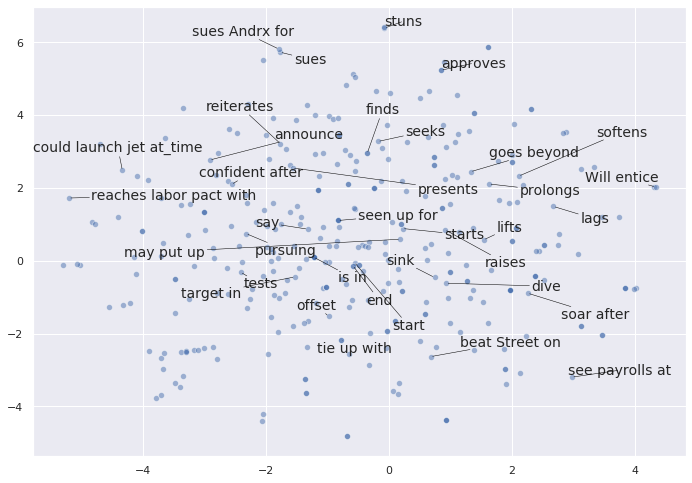

In [0]:
plot_tsne(tsne_relation, relationDF)

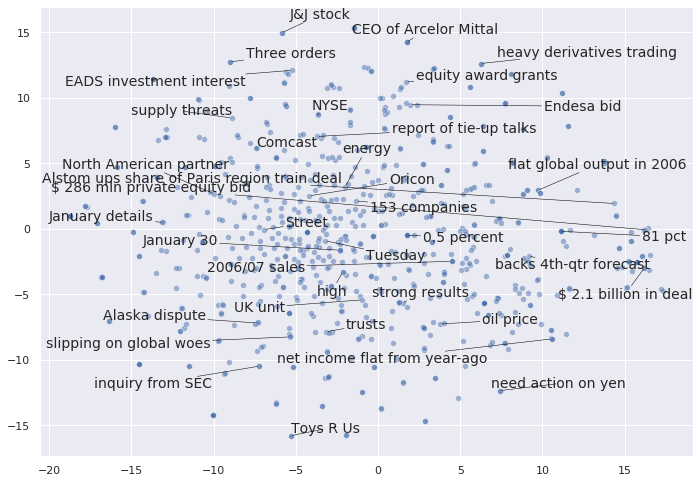

In [0]:
plot_tsne(tsne_object, objectDF, skip=20)

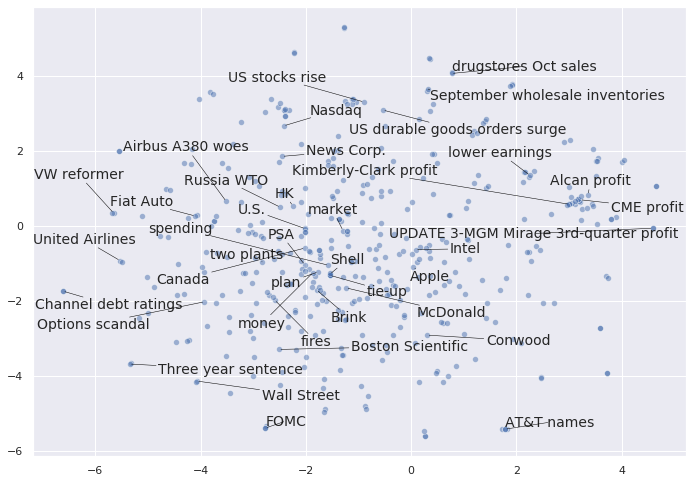

In [0]:
plot_tsne(tsne_subject, subjectDF)

# **Averaging word embeddings each day**

In [0]:
# Load word2vec results
vec = pd.read_pickle(DATA_PATH + "/wordEmbedingVecDF.pkl")
# Sum values of first three columns for each row
vec['vector'] = vec.object + vec.relation + vec.subject
# Drop extraneous columns
vec = vec.drop(['object', 'relation', 'subject'], axis = 1)

In [0]:
# Store vec object
vec.to_pickle(DATA_PATH + "/vec.pkl")

In [0]:
# Remove intra-day time information
from time import gmtime, strftime
for index, row in vec.iterrows():
  row['time'] = strftime("%Y-%m-%d", row['time'])

In [0]:
# Create a new data frame to store average vector at each time
ave_vec = pd.DataFrame(columns=['ave_vec', 'time'])
grouped = vec.groupby('time')
for name, group in grouped:
  curr_time = name
  all_vec = group['vector']
  all_vec = all_vec.to_numpy()
  curr_ave = np.mean(all_vec)
  ave_vec = ave_vec.append({'time': curr_time, 'ave_vec': curr_ave}, ignore_index=True)

In [0]:
# Store ave_vec object
ave_vec.to_pickle(DATA_PATH + "/ave_vec.pkl")

# **Remove Weekend and Holiday Data**

In [0]:
all_data = pd.read_pickle(DATA_PATH + "/ave_vec.pkl")

In [0]:
all_data.iloc[[0,3]]


ave_vec        time
0  [-0.058512369791666664, -0.2357177734375, -0.6...  2006-10-20
3  [-0.13548544178838315, 0.31165338599163556, 0....  2006-10-23

In [0]:
SP500_movement_direction = pd.read_pickle(DATA_PATH + "/SP500_movement_direction.pkl")
real_time=set(SP500_movement_direction['time'])
del_list=[]
for i in range(len(all_data['time'])):
  if not all_data['time'][i] in real_time:
    del_list.append(i)



In [0]:
data=all_data.drop(del_list)
data=data.reset_index(drop=True)

In [0]:
data

ave_vec        time
0     [-0.058512369791666664, -0.2357177734375, -0.6...  2006-10-20
1     [-0.13548544178838315, 0.31165338599163556, 0....  2006-10-23
2     [-0.05218315124511719, 0.13503500131460336, -0...  2006-10-24
3     [-0.09298992156982422, 0.18503570556640625, -0...  2006-10-25
4     [-0.040431532748909885, 0.1516815895257994, -0...  2006-10-26
...                                                 ...         ...
1783  [0.29364871268089, 0.1492408385643592, -0.3249...  2013-11-20
1784  [0.26031364192807577, 0.13052884853952298, -0....  2013-11-21
1785  [0.3343591461050776, 0.1107044179075578, -0.39...  2013-11-22
1786  [0.2522832626054267, 0.1608058147821106, -0.36...  2013-11-25
1787  [0.203892379476313, 0.10268629642955043, -0.39...  2013-11-26

[1788 rows x 2 columns]

# Logistic Regression 

In [0]:
import sklearn
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold # import KFold
from sklearn import datasets

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

X = list(data['ave_vec'])
y = list(SP500_movement_direction['GSPC.Adjusted'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(solver="lbfgs")
model.fit(X_train, y_train)

#model evaluation
train_score = model.score(X_train, y_train)
y_pred_train = model.predict(X_train)
train_precision, train_recall, train_fscore, train_support = precision_recall_fscore_support(y_train, y_pred_train, average="binary")
test_score = model.score(X_test, y_test)
y_pred_test = model.predict(X_test)
test_precision, test_recall, test_fscore, test_support = precision_recall_fscore_support(y_test, y_pred_test, average="binary")

result = {
  'train_accuracy': train_score, 
  'train_precision': train_precision, 
  'train_recall': train_recall, 
  'train_fscore': train_fscore, 
  'test_accuracy': test_score, 
  'test_precision': test_precision, 
  'test_recall': test_recall, 
  'test_fscore': test_fscore,
}

print(result)


{'train_accuracy': 0.6923076923076923, 'train_precision': 0.6867724867724868, 'train_recall': 0.8184110970996217, 'train_fscore': 0.7468354430379747, 'test_accuracy': 0.5810055865921788, 'test_precision': 0.5850622406639004, 'test_recall': 0.7382198952879581, 'test_fscore': 0.6527777777777778}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Constructing training and validation datasets

Yitian-->Julie: why choose 1407? Can you specify how did you choose training and validation sets? 

In [0]:
training_dataset={} #a dictionary, key: date, value: training value
val_dataset={}
lt_days=30
mt_days=7
for i in range(lt_days,1407):
  lt=np.array(data['ave_vec'][i-lt_days:i])
  mt=np.array(data['ave_vec'][i-mt_days:i])
  st=np.array(data['ave_vec'][i-1])
  label=SP500_movement_direction['GSPC.Adjusted	'][i]
  training_dataset[data['time'][i]]=[lt,mt,st,label]
for i in range(407,len(data['time'])):
  lt=np.array(data['ave_vec'][i-lt_days:i])
  mt=np.array(data['ave_vec'][i-mt_days:i])
  st=np.array(data['ave_vec'][i-1])
  label=SP500_movement_direction['GSPC.Adjusted	'][i]
  val_dataset[data['time'][i]]=[lt,mt,st,label]

KeyError: ignored

Run CNN

(1,)
1
Train Epoch: [ 0] [   0/1377] time: 0.4400, loss: 0.59397584, ce_loss: 0.56179547, l2_loss: 321.80383301
[0.275677] [1]
(1,)
1
Train Epoch: [ 0] [   1/1377] time: 0.4535, loss: 0.58501530, ce_loss: 0.55297875, l2_loss: 320.36560059
(1,)
0
Train Epoch: [ 0] [   2/1377] time: 0.4672, loss: 0.88529879, ce_loss: 0.85340762, l2_loss: 318.91174316
(1,)
0
Train Epoch: [ 0] [   3/1377] time: 0.4785, loss: 0.88440692, ce_loss: 0.85266113, l2_loss: 317.45816040
(1,)
1
Train Epoch: [ 0] [   4/1377] time: 0.4924, loss: 0.59552377, ce_loss: 0.56392324, l2_loss: 316.00546265
(1,)
1
Train Epoch: [ 0] [   5/1377] time: 0.5037, loss: 0.58723664, ce_loss: 0.55578053, l2_loss: 314.56127930
(1,)
0
Train Epoch: [ 0] [   6/1377] time: 0.5159, loss: 0.87247974, ce_loss: 0.84116715, l2_loss: 313.12603760
(1,)
1
Train Epoch: [ 0] [   7/1377] time: 0.5288, loss: 0.59296781, ce_loss: 0.56179798, l2_loss: 311.69836426
(1,)
1
Train Epoch: [ 0] [   8/1377] time: 0.5392, loss: 0.58560073, ce_loss: 0.55457270,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:306: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:329: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:358: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:361: RuntimeWarning: invalid value encountered in true_divide


(1,)
1
Train Epoch: [ 1] [   0/1377] time: 18.5929, loss: 0.62058407, ce_loss: 0.60769409, l2_loss: 128.89968872
(1,)
1
Train Epoch: [ 1] [   1/1377] time: 18.6032, loss: 0.61608040, ce_loss: 0.60319197, l2_loss: 128.88446045
(1,)
0
Train Epoch: [ 1] [   2/1377] time: 18.6128, loss: 0.80127710, ce_loss: 0.78839004, l2_loss: 128.87039185
(1,)
0
Train Epoch: [ 1] [   3/1377] time: 18.6226, loss: 0.80152965, ce_loss: 0.78864390, l2_loss: 128.85740662
(1,)
1
Train Epoch: [ 1] [   4/1377] time: 18.6319, loss: 0.62028044, ce_loss: 0.60739613, l2_loss: 128.84329224
(1,)
1
Train Epoch: [ 1] [   5/1377] time: 18.6414, loss: 0.61822778, ce_loss: 0.60534495, l2_loss: 128.82821655
(1,)
0
Train Epoch: [ 1] [   6/1377] time: 18.6504, loss: 0.79187840, ce_loss: 0.77899694, l2_loss: 128.81446838
(1,)
1
Train Epoch: [ 1] [   7/1377] time: 18.6599, loss: 0.62542343, ce_loss: 0.61254346, l2_loss: 128.79948425
(1,)
1
Train Epoch: [ 1] [   8/1377] time: 18.6704, loss: 0.61852223, ce_loss: 0.60564387, l2_lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:306: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:329: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:358: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:361: RuntimeWarning: invalid value encountered in true_divide


(1,)
1
Train Epoch: [ 2] [   0/1377] time: 36.6659, loss: 0.62134647, ce_loss: 0.61029071, l2_loss: 110.55789185
(1,)
1
Train Epoch: [ 2] [   1/1377] time: 36.6759, loss: 0.61727768, ce_loss: 0.60622293, l2_loss: 110.54776764
(1,)
0
Train Epoch: [ 2] [   2/1377] time: 36.6877, loss: 0.79468787, ce_loss: 0.78363395, l2_loss: 110.53903198
(1,)
0
Train Epoch: [ 2] [   3/1377] time: 36.6972, loss: 0.79548460, ce_loss: 0.78443146, l2_loss: 110.53153229
(1,)
1
Train Epoch: [ 2] [   4/1377] time: 36.7064, loss: 0.61908150, ce_loss: 0.60802919, l2_loss: 110.52282715
(1,)
1
Train Epoch: [ 2] [   5/1377] time: 36.7159, loss: 0.61801422, ce_loss: 0.60696292, l2_loss: 110.51308441
(1,)
0
Train Epoch: [ 2] [   6/1377] time: 36.7252, loss: 0.78729409, ce_loss: 0.77624363, l2_loss: 110.50473785
(1,)
1
Train Epoch: [ 2] [   7/1377] time: 36.7348, loss: 0.62547100, ce_loss: 0.61442149, l2_loss: 110.49504089
(1,)
1
Train Epoch: [ 2] [   8/1377] time: 36.7437, loss: 0.61907935, ce_loss: 0.60803092, l2_lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:306: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:312: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:319: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained

(1,)
1
Train Epoch: [ 3] [   0/1377] time: 54.5537, loss: 0.61957765, ce_loss: 0.60980958, l2_loss: 97.68051910
(1,)
1
Train Epoch: [ 3] [   1/1377] time: 54.5642, loss: 0.61580598, ce_loss: 0.60603869, l2_loss: 97.67296600
(1,)
0
Train Epoch: [ 3] [   2/1377] time: 54.5741, loss: 0.79230022, ce_loss: 0.78253353, l2_loss: 97.66690063
(1,)
0
Train Epoch: [ 3] [   3/1377] time: 54.5849, loss: 0.79368907, ce_loss: 0.78392285, l2_loss: 97.66210938
(1,)
1
Train Epoch: [ 3] [   4/1377] time: 54.5937, loss: 0.61554837, ce_loss: 0.60578275, l2_loss: 97.65616608
(1,)
1
Train Epoch: [ 3] [   5/1377] time: 54.6023, loss: 0.61527967, ce_loss: 0.60551476, l2_loss: 97.64914703
(1,)
0
Train Epoch: [ 3] [   6/1377] time: 54.6117, loss: 0.78666252, ce_loss: 0.77689815, l2_loss: 97.64353943
(1,)
1
Train Epoch: [ 3] [   7/1377] time: 54.6205, loss: 0.62296706, ce_loss: 0.61320341, l2_loss: 97.63659668
(1,)
1
Train Epoch: [ 3] [   8/1377] time: 54.6297, loss: 0.61709386, ce_loss: 0.60733104, l2_loss: 97.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

(1,)
1
Train Epoch: [ 4] [   0/1377] time: 72.7516, loss: 0.62379342, ce_loss: 0.61500621, l2_loss: 87.87204742
(1,)
1
Train Epoch: [ 4] [   1/1377] time: 72.7621, loss: 0.62079555, ce_loss: 0.61200887, l2_loss: 87.86664581
(1,)
0
Train Epoch: [ 4] [   2/1377] time: 72.7725, loss: 0.78418899, ce_loss: 0.77540267, l2_loss: 87.86318970
(1,)
0
Train Epoch: [ 4] [   3/1377] time: 72.7830, loss: 0.78600532, ce_loss: 0.77721918, l2_loss: 87.86138916
(1,)
1
Train Epoch: [ 4] [   4/1377] time: 72.7931, loss: 0.61853004, ce_loss: 0.60974425, l2_loss: 87.85791016
(1,)
1
Train Epoch: [ 4] [   5/1377] time: 72.8033, loss: 0.61891127, ce_loss: 0.61012596, l2_loss: 87.85283661
(1,)
0
Train Epoch: [ 4] [   6/1377] time: 72.8126, loss: 0.78048897, ce_loss: 0.77170402, l2_loss: 87.84947205
(1,)
1
Train Epoch: [ 4] [   7/1377] time: 72.8227, loss: 0.62647069, ce_loss: 0.61768627, l2_loss: 87.84429932
(1,)
1
Train Epoch: [ 4] [   8/1377] time: 72.8327, loss: 0.62175912, ce_loss: 0.61297536, l2_loss: 87.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

(1,)
1
Train Epoch: [ 5] [   0/1377] time: 91.5126, loss: 0.62049443, ce_loss: 0.61252290, l2_loss: 79.71547699
(1,)
1
Train Epoch: [ 5] [   1/1377] time: 91.5234, loss: 0.61761743, ce_loss: 0.60964638, l2_loss: 79.71032715
(1,)
0
Train Epoch: [ 5] [   2/1377] time: 91.5336, loss: 0.78495163, ce_loss: 0.77698094, l2_loss: 79.70685577
(1,)
0
Train Epoch: [ 5] [   3/1377] time: 91.5441, loss: 0.78685057, ce_loss: 0.77888012, l2_loss: 79.70470428
(1,)
1
Train Epoch: [ 5] [   4/1377] time: 91.5545, loss: 0.61442459, ce_loss: 0.60645443, l2_loss: 79.70145416
(1,)
1
Train Epoch: [ 5] [   5/1377] time: 91.5641, loss: 0.61481768, ce_loss: 0.60684794, l2_loss: 79.69712067
(1,)
0
Train Epoch: [ 5] [   6/1377] time: 91.5741, loss: 0.78277618, ce_loss: 0.77480674, l2_loss: 79.69412231
(1,)
1
Train Epoch: [ 5] [   7/1377] time: 91.5840, loss: 0.62265164, ce_loss: 0.61468267, l2_loss: 79.68975067
(1,)
1
Train Epoch: [ 5] [   8/1377] time: 91.5945, loss: 0.61859572, ce_loss: 0.61062729, l2_loss: 79.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

(1,)
1
Train Epoch: [ 6] [   0/1377] time: 109.6958, loss: 0.62970030, ce_loss: 0.62240702, l2_loss: 72.93304443
(1,)
1
Train Epoch: [ 6] [   1/1377] time: 109.7069, loss: 0.62623656, ce_loss: 0.61894357, l2_loss: 72.92961884
(1,)
0
Train Epoch: [ 6] [   2/1377] time: 109.7181, loss: 0.77305287, ce_loss: 0.76576006, l2_loss: 72.92807007
(1,)
0
Train Epoch: [ 6] [   3/1377] time: 109.7286, loss: 0.77357680, ce_loss: 0.76628399, l2_loss: 72.92815399
(1,)
1
Train Epoch: [ 6] [   4/1377] time: 109.7386, loss: 0.62433189, ce_loss: 0.61703926, l2_loss: 72.92655182
(1,)
1
Train Epoch: [ 6] [   5/1377] time: 109.7481, loss: 0.62490863, ce_loss: 0.61761630, l2_loss: 72.92339325
(1,)
0
Train Epoch: [ 6] [   6/1377] time: 109.7579, loss: 0.77076268, ce_loss: 0.76347047, l2_loss: 72.92182922
(1,)
1
Train Epoch: [ 6] [   7/1377] time: 109.7683, loss: 0.63124460, ce_loss: 0.62395275, l2_loss: 72.91853333
(1,)
1
Train Epoch: [ 6] [   8/1377] time: 109.7785, loss: 0.62816930, ce_loss: 0.62087792, l2_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

(1,)
1
Train Epoch: [ 7] [   0/1377] time: 127.8875, loss: 0.61783653, ce_loss: 0.61112082, l2_loss: 67.15711212
(1,)
1
Train Epoch: [ 7] [   1/1377] time: 127.8983, loss: 0.61458236, ce_loss: 0.60786700, l2_loss: 67.15355682
(1,)
0
Train Epoch: [ 7] [   2/1377] time: 127.9081, loss: 0.78320241, ce_loss: 0.77648723, l2_loss: 67.15162659
(1,)
0
Train Epoch: [ 7] [   3/1377] time: 127.9179, loss: 0.78527576, ce_loss: 0.77856064, l2_loss: 67.15105438
(1,)
1
Train Epoch: [ 7] [   4/1377] time: 127.9274, loss: 0.61018920, ce_loss: 0.60347426, l2_loss: 67.14952087
(1,)
1
Train Epoch: [ 7] [   5/1377] time: 127.9374, loss: 0.61186153, ce_loss: 0.60514683, l2_loss: 67.14701080
(1,)
0
Train Epoch: [ 7] [   6/1377] time: 127.9480, loss: 0.78313744, ce_loss: 0.77642286, l2_loss: 67.14573669
(1,)
1
Train Epoch: [ 7] [   7/1377] time: 127.9578, loss: 0.61791670, ce_loss: 0.61120236, l2_loss: 67.14319611
(1,)
1
Train Epoch: [ 7] [   8/1377] time: 127.9672, loss: 0.61554092, ce_loss: 0.60882699, l2_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

(1,)
1
Train Epoch: [ 8] [   0/1377] time: 146.2032, loss: 0.62643844, ce_loss: 0.62018239, l2_loss: 62.56037903
(1,)
1
Train Epoch: [ 8] [   1/1377] time: 146.2133, loss: 0.62233818, ce_loss: 0.61608237, l2_loss: 62.55820084
(1,)
0
Train Epoch: [ 8] [   2/1377] time: 146.2230, loss: 0.77324504, ce_loss: 0.76698923, l2_loss: 62.55784607
(1,)
0
Train Epoch: [ 8] [   3/1377] time: 146.2338, loss: 0.77403158, ce_loss: 0.76777565, l2_loss: 62.55906296
(1,)
1
Train Epoch: [ 8] [   4/1377] time: 146.2434, loss: 0.61947519, ce_loss: 0.61321932, l2_loss: 62.55871582
(1,)
1
Train Epoch: [ 8] [   5/1377] time: 146.2536, loss: 0.62112945, ce_loss: 0.61487377, l2_loss: 62.55689621
(1,)
0
Train Epoch: [ 8] [   6/1377] time: 146.2634, loss: 0.77259344, ce_loss: 0.76633775, l2_loss: 62.55657959
(1,)
1
Train Epoch: [ 8] [   7/1377] time: 146.2736, loss: 0.62613052, ce_loss: 0.61987507, l2_loss: 62.55461884
(1,)
1
Train Epoch: [ 8] [   8/1377] time: 146.2844, loss: 0.62476349, ce_loss: 0.61850840, l2_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

(1,)
1
Train Epoch: [ 9] [   0/1377] time: 165.1523, loss: 0.61540377, ce_loss: 0.60957527, l2_loss: 58.28478241
(1,)
1
Train Epoch: [ 9] [   1/1377] time: 165.1624, loss: 0.61168146, ce_loss: 0.60585320, l2_loss: 58.28273392
(1,)
0
Train Epoch: [ 9] [   2/1377] time: 165.1722, loss: 0.78221226, ce_loss: 0.77638406, l2_loss: 58.28218842
(1,)
0
Train Epoch: [ 9] [   3/1377] time: 165.1809, loss: 0.78433102, ce_loss: 0.77850276, l2_loss: 58.28290176
(1,)
1
Train Epoch: [ 9] [   4/1377] time: 165.1899, loss: 0.60648191, ce_loss: 0.60065365, l2_loss: 58.28274918
(1,)
1
Train Epoch: [ 9] [   5/1377] time: 165.1986, loss: 0.60924858, ce_loss: 0.60342044, l2_loss: 58.28165436
(1,)
0
Train Epoch: [ 9] [   6/1377] time: 165.2080, loss: 0.78433359, ce_loss: 0.77850544, l2_loss: 58.28162766
(1,)
1
Train Epoch: [ 9] [   7/1377] time: 165.2168, loss: 0.61383647, ce_loss: 0.60800844, l2_loss: 58.28045654
(1,)
1
Train Epoch: [ 9] [   8/1377] time: 165.2257, loss: 0.61306649, ce_loss: 0.60723865, l2_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


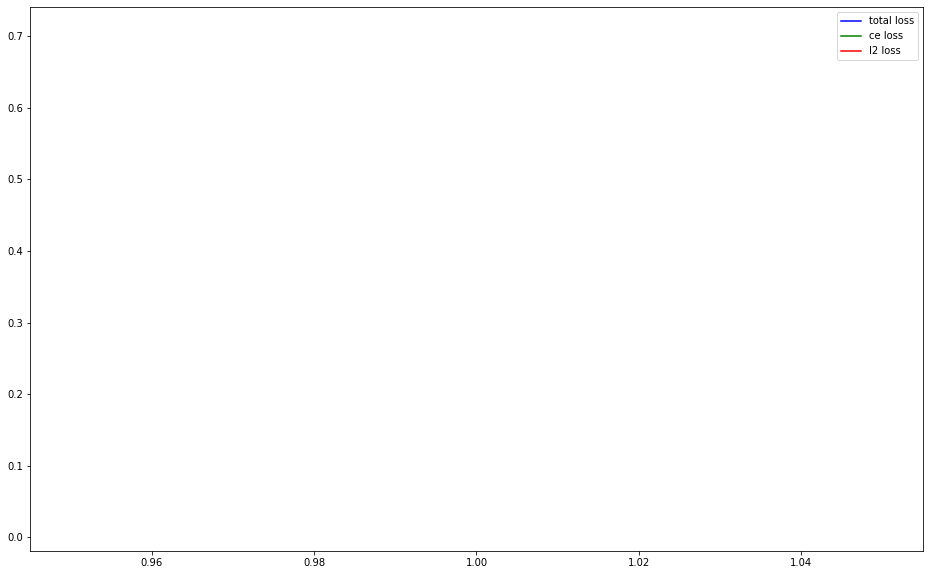

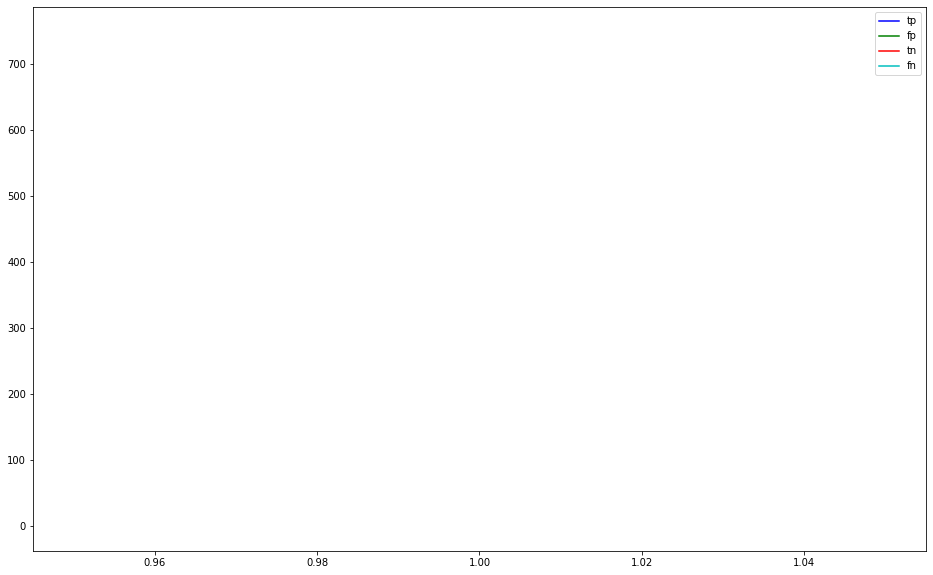

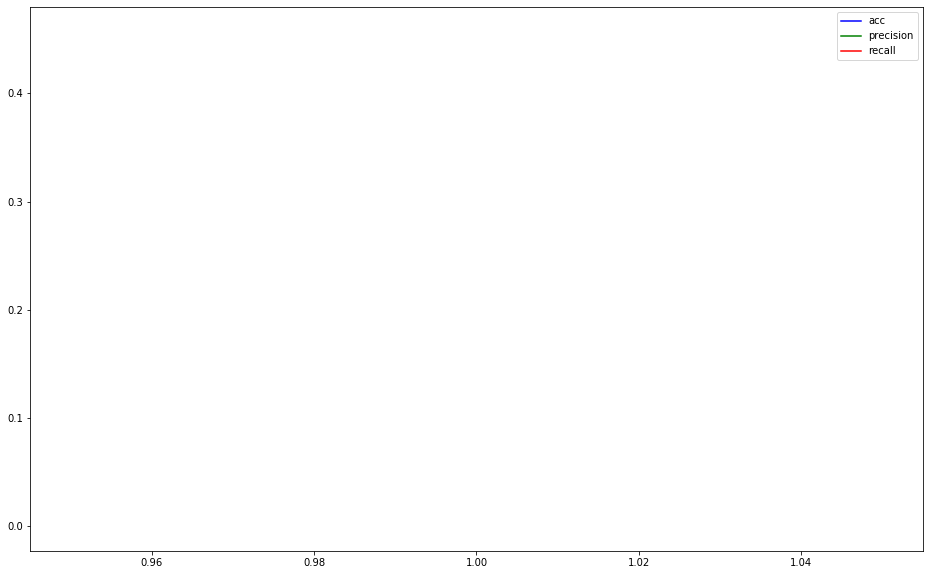

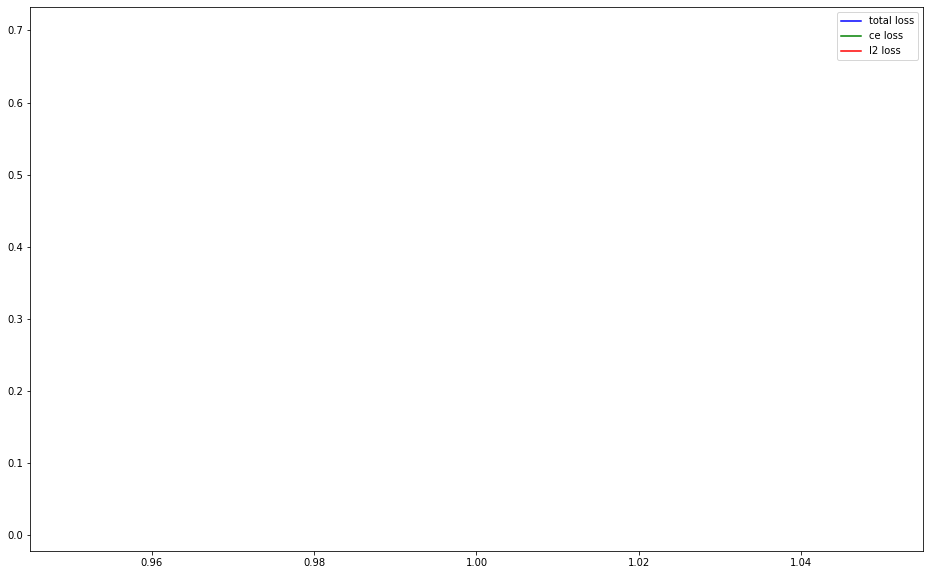

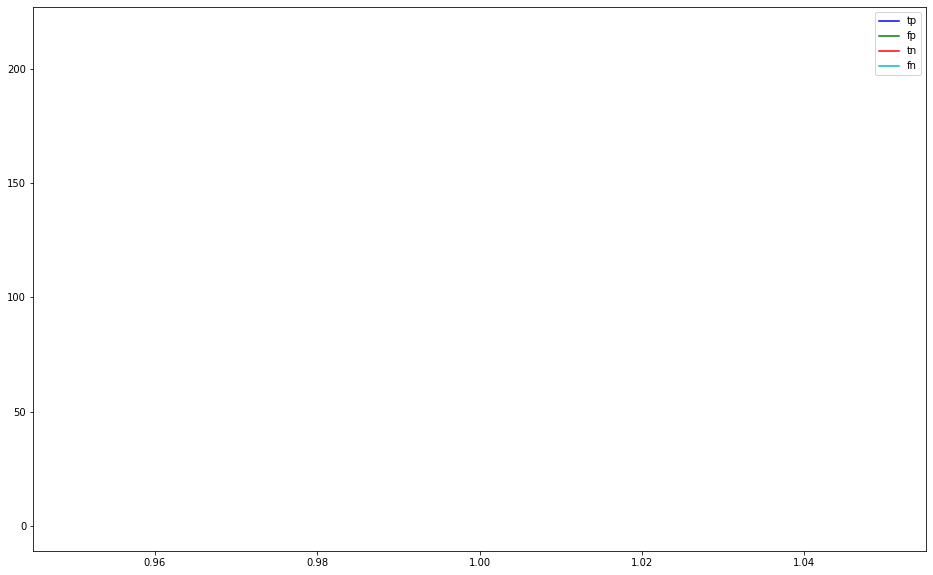

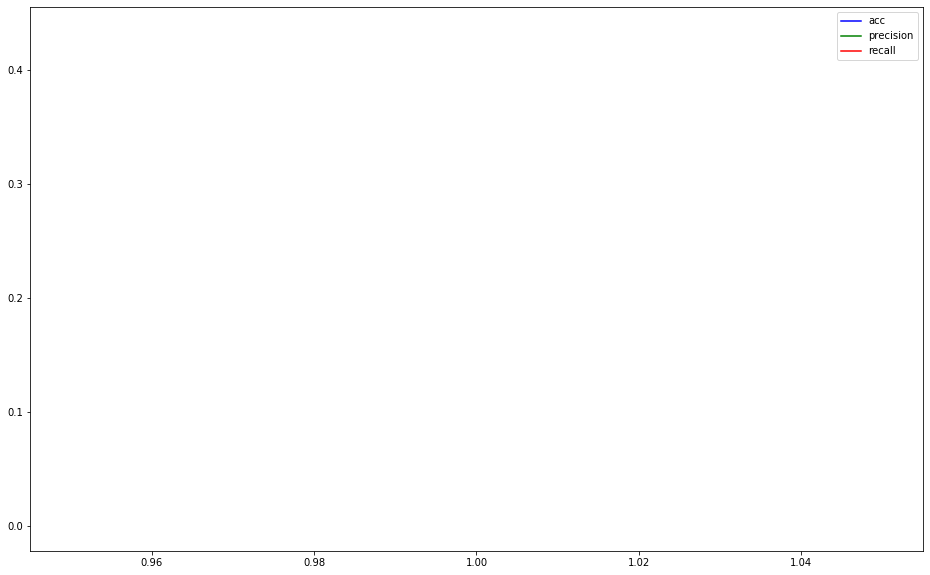

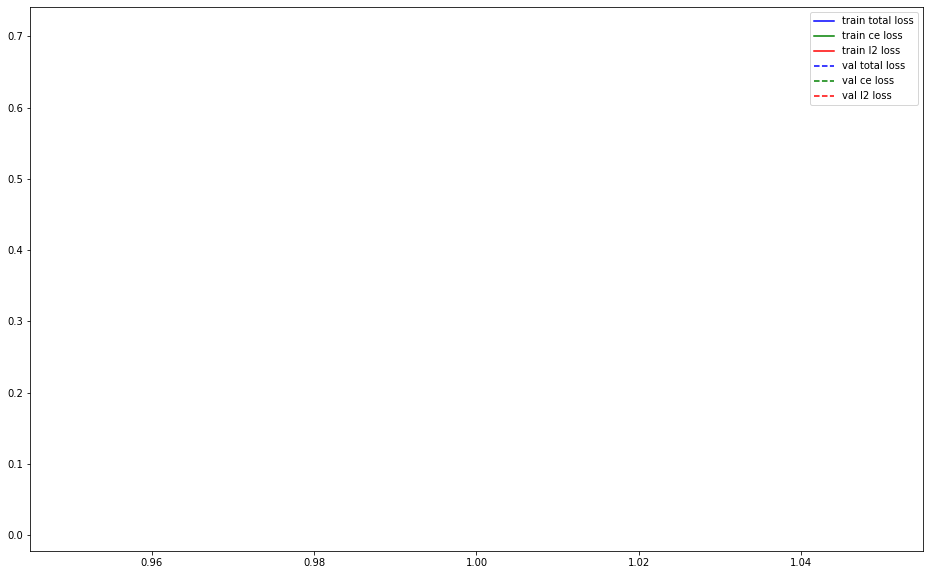

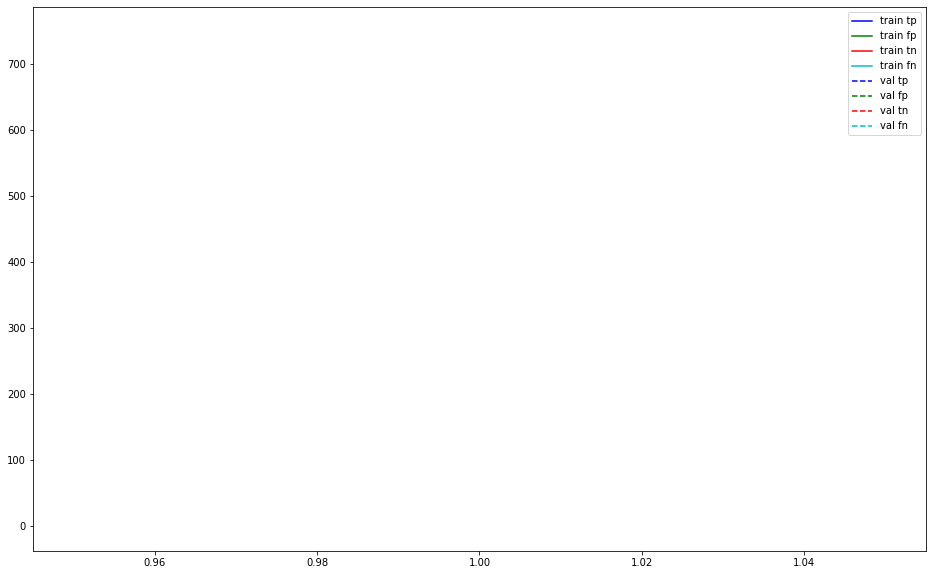

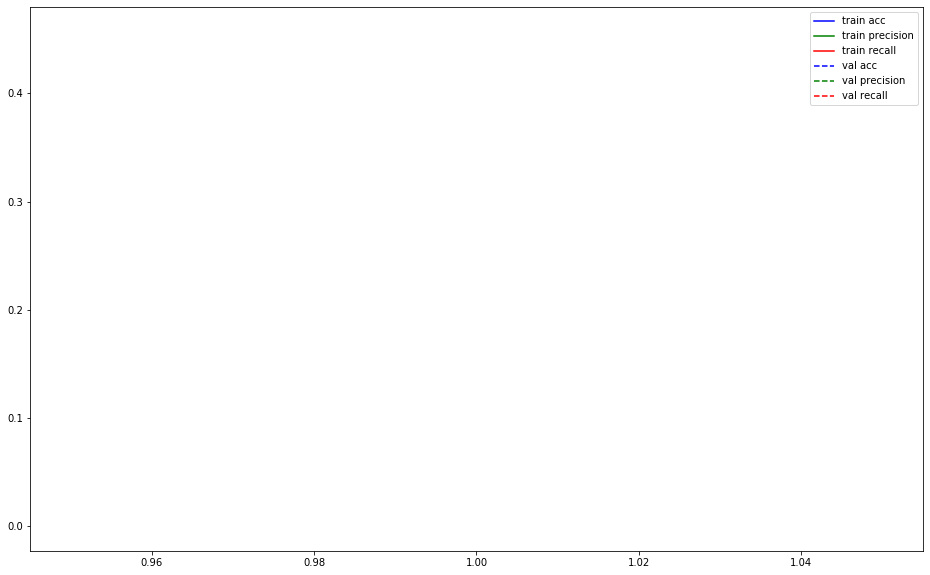

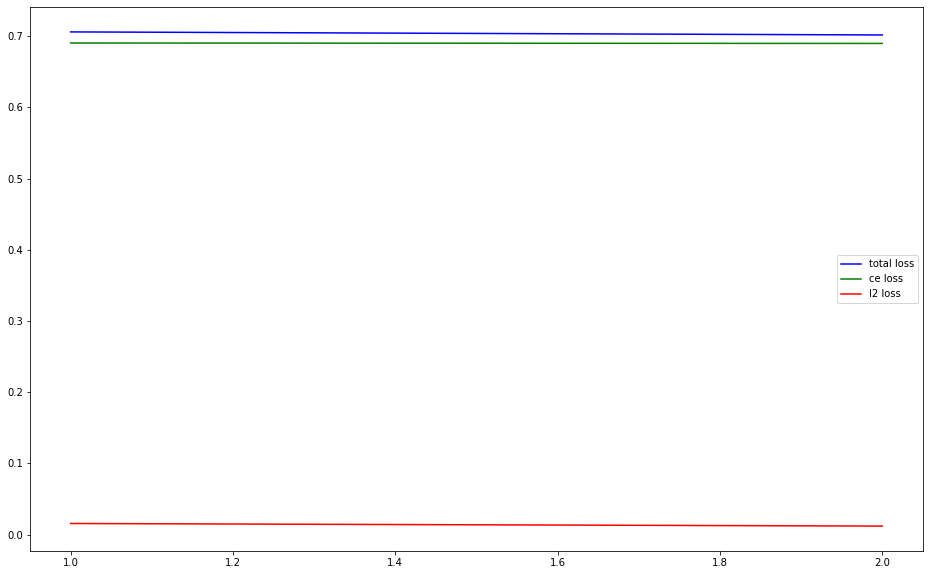

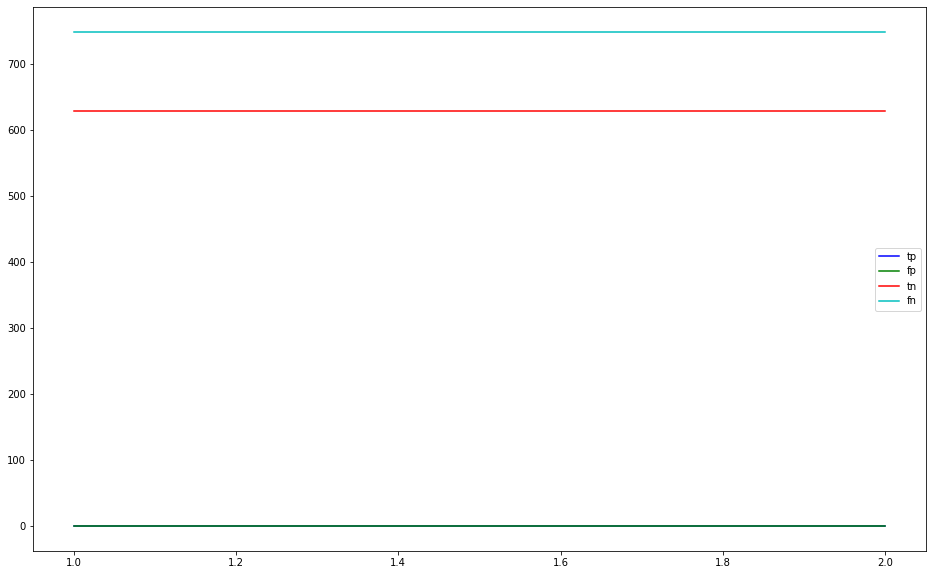

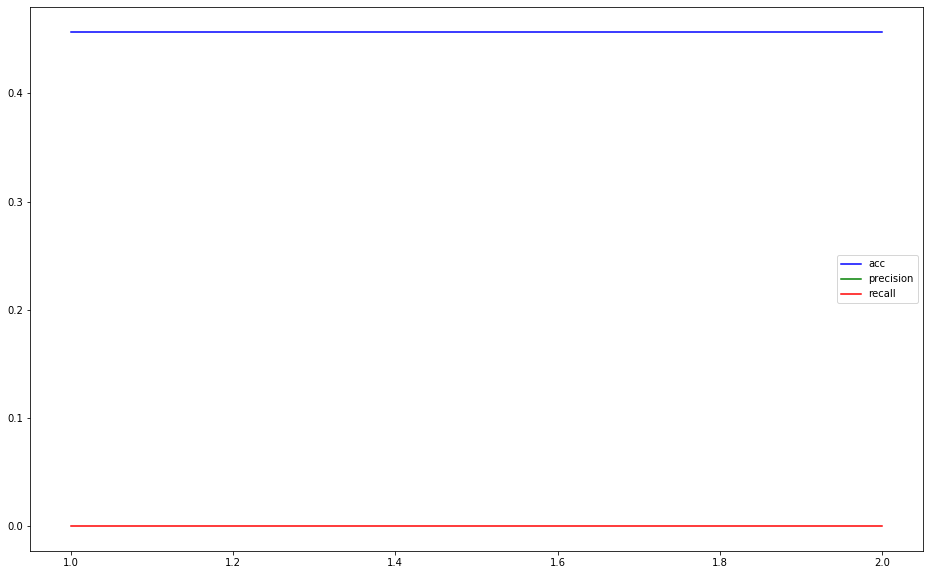

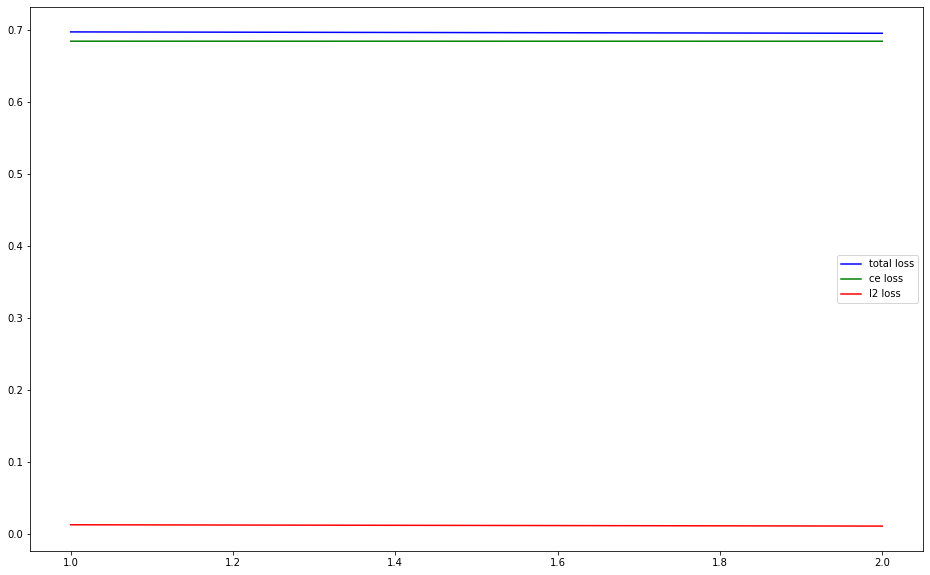

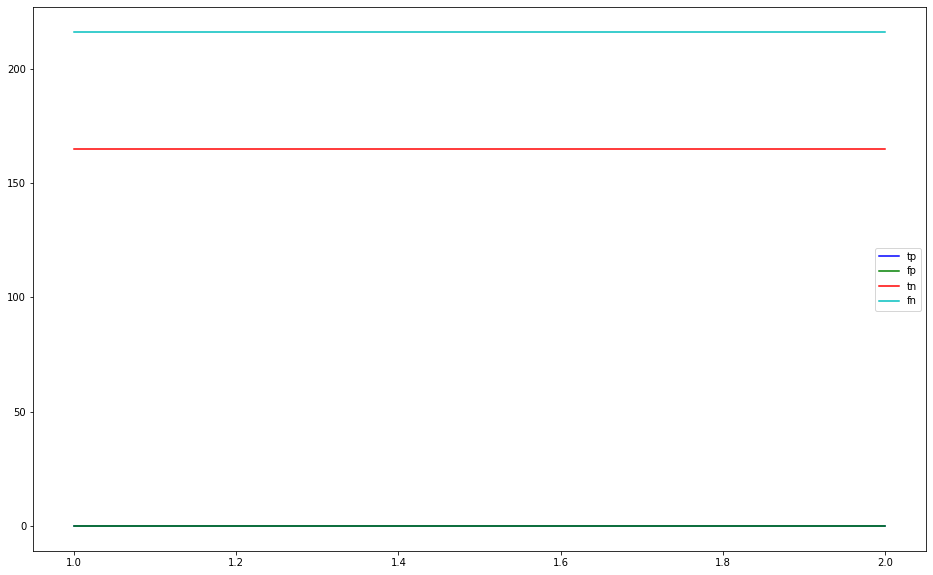

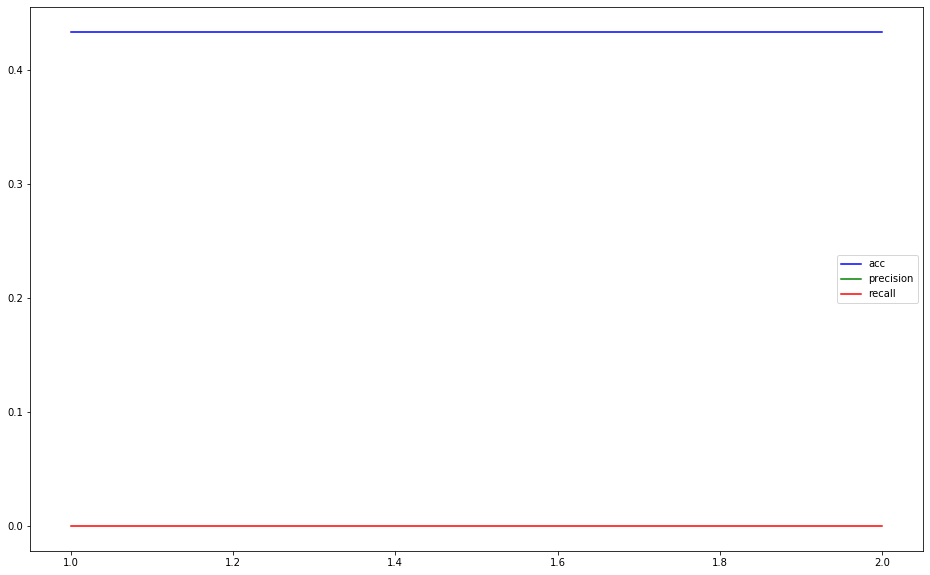

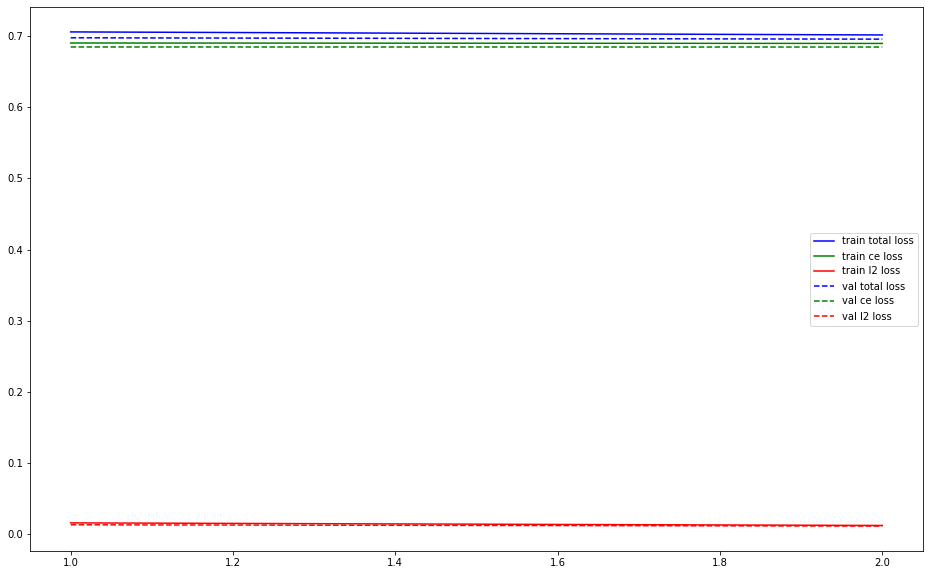

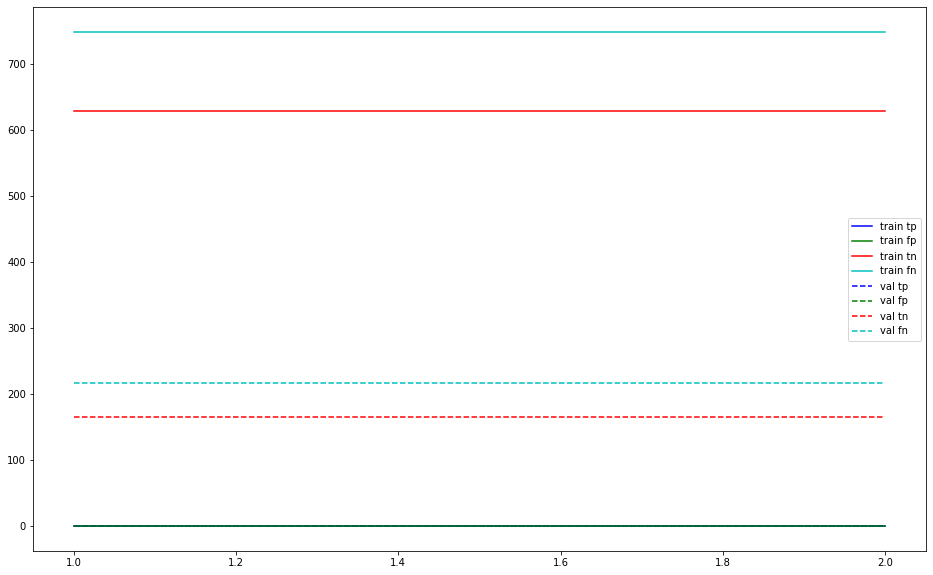

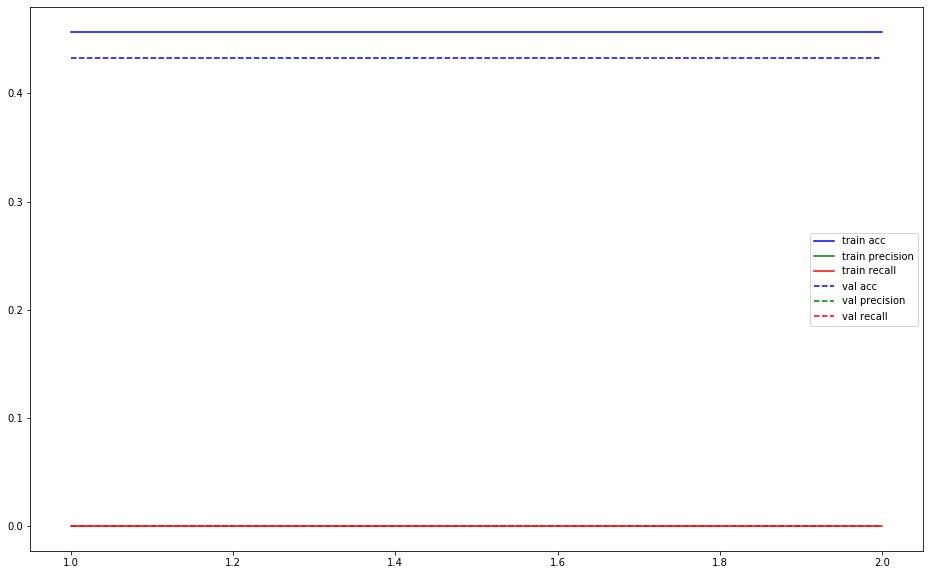

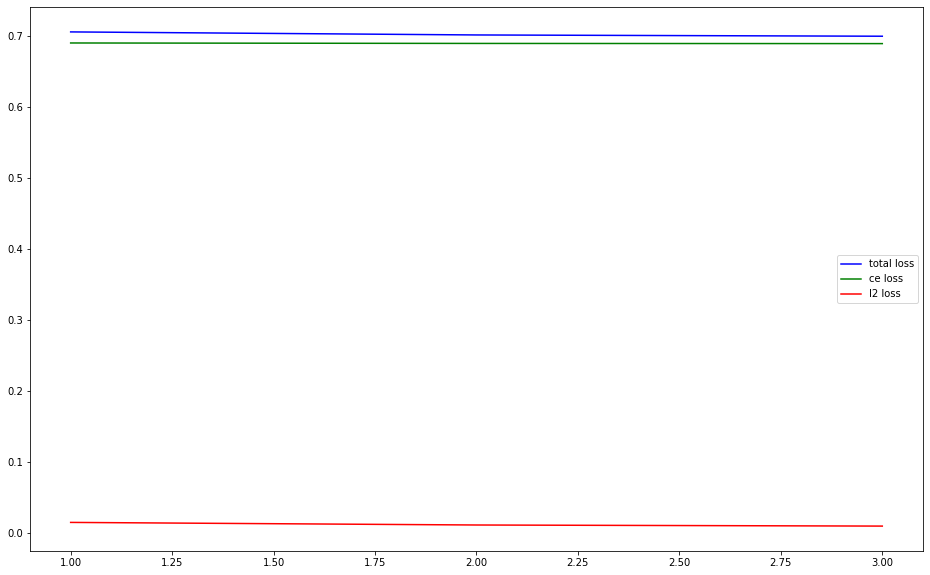

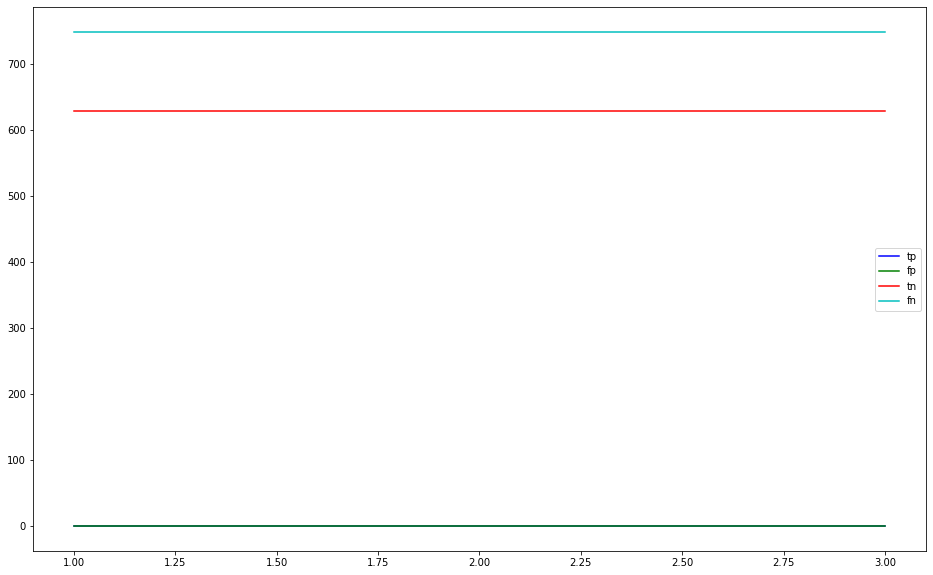

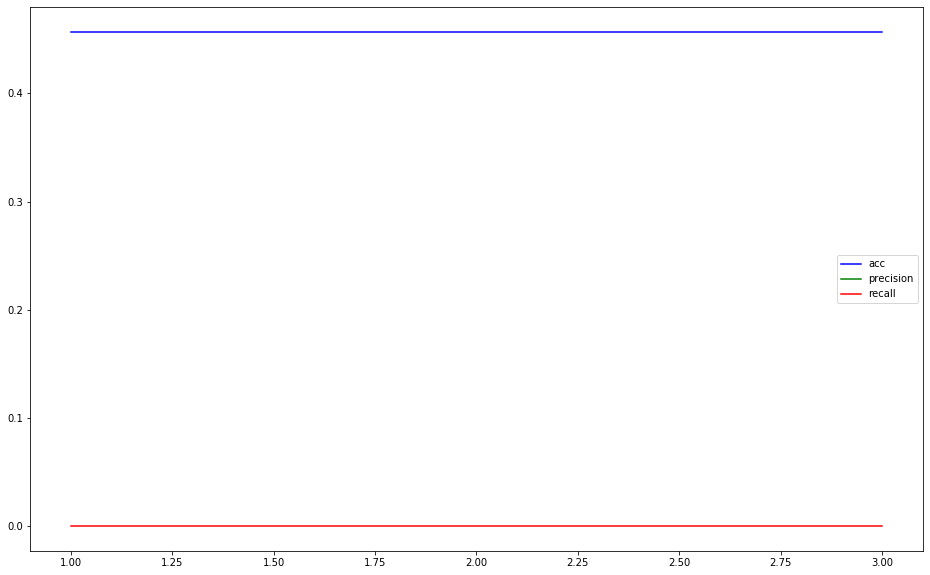

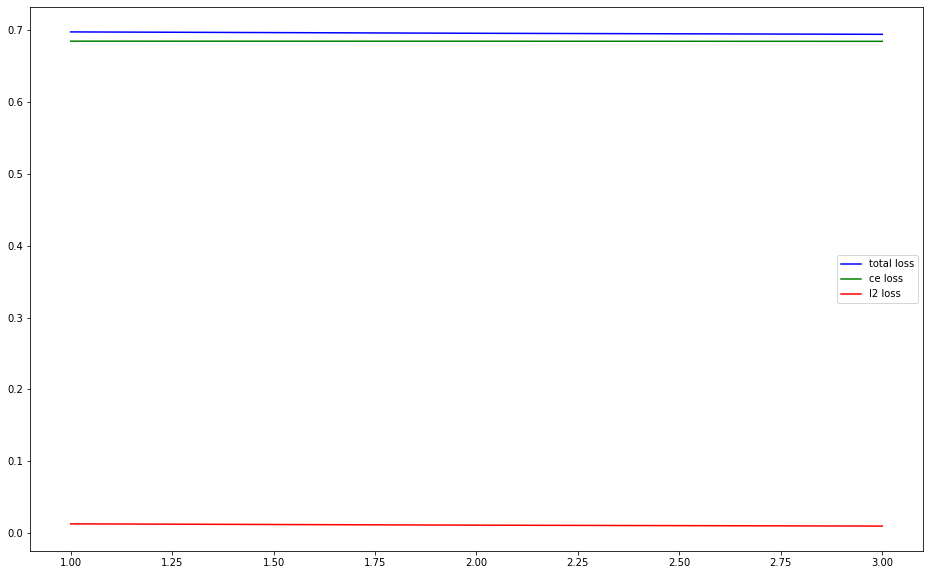

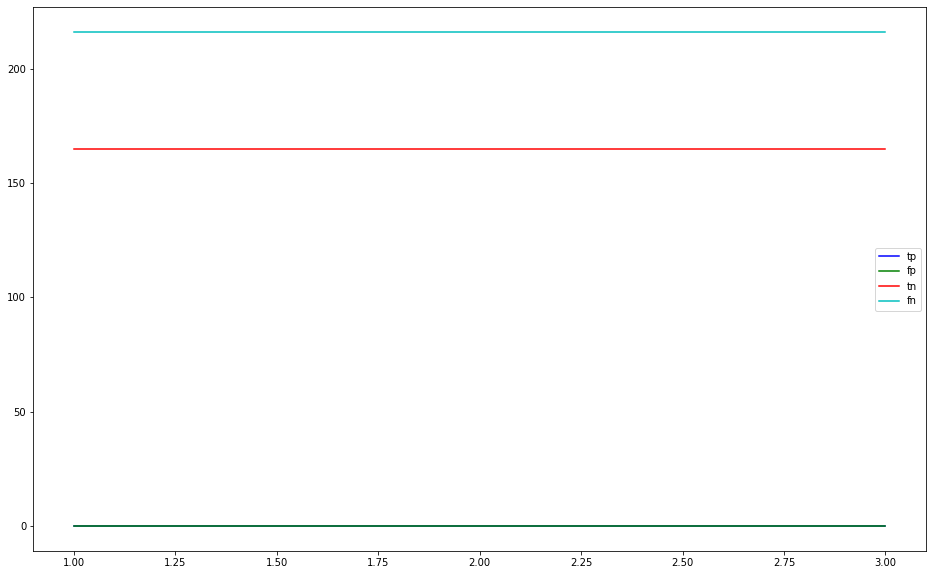

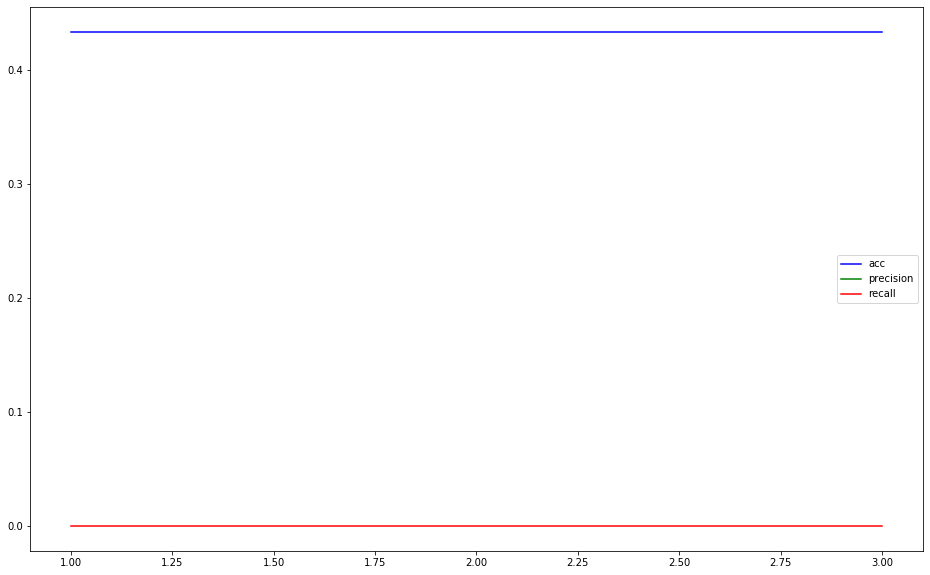

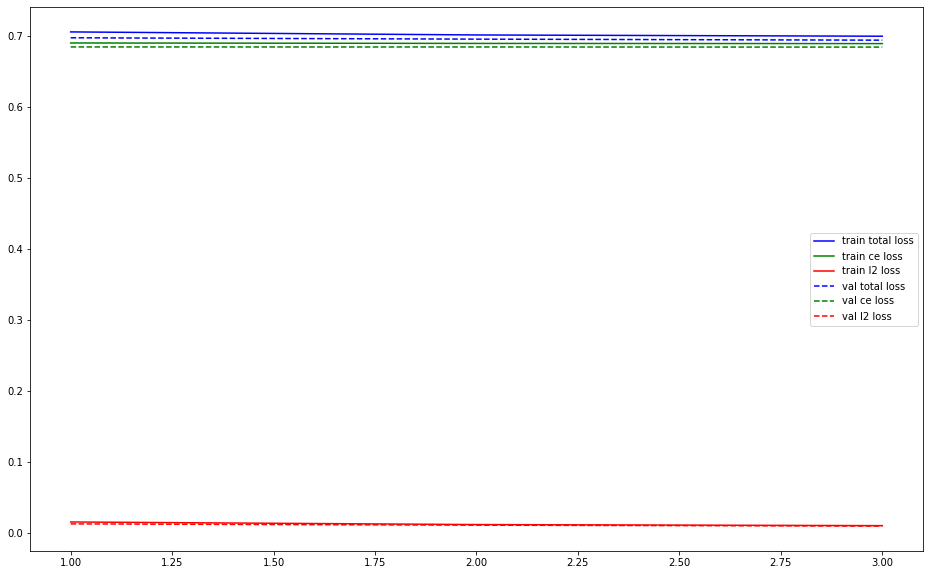

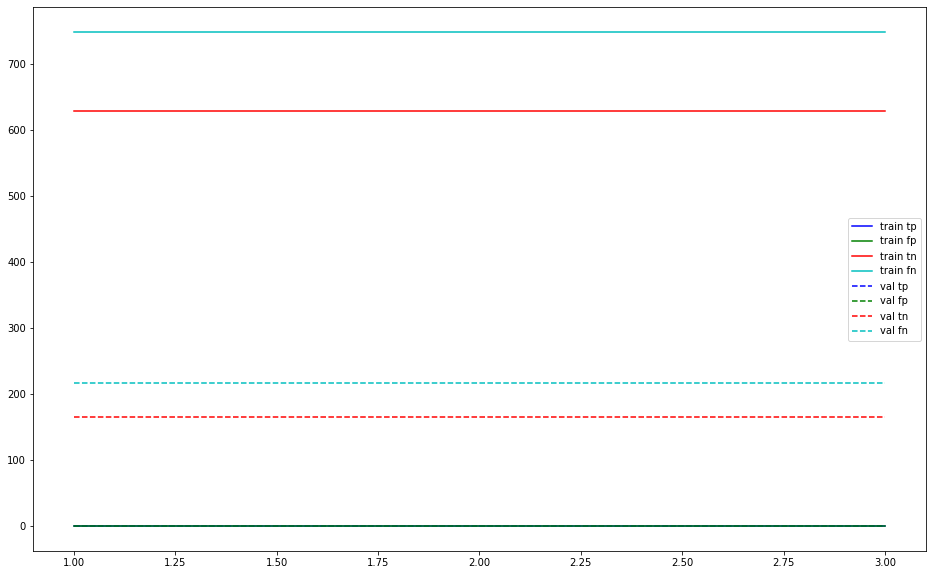

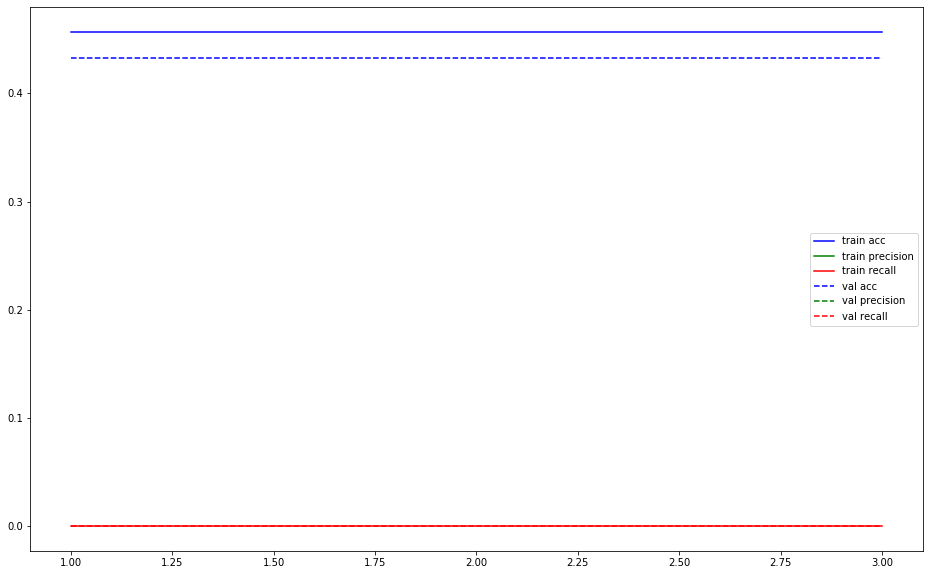

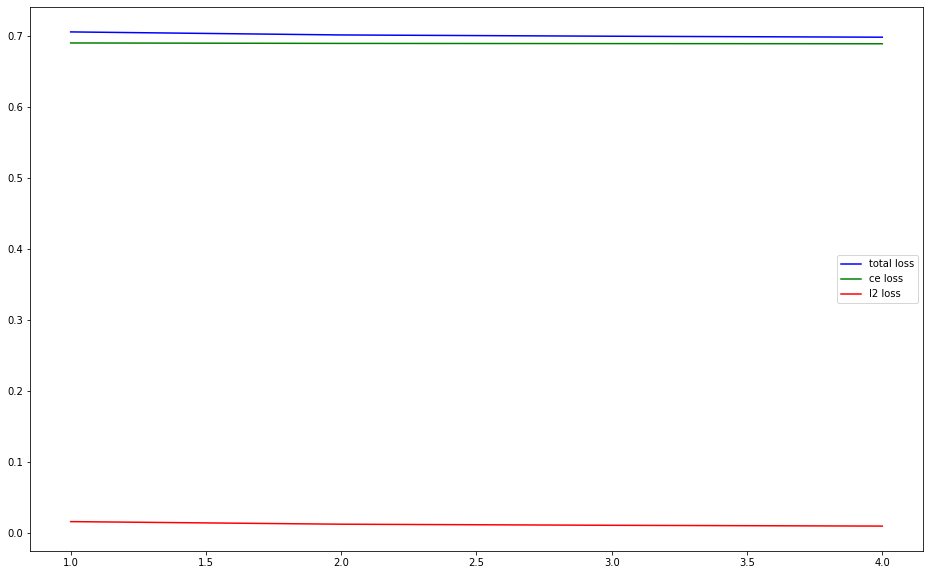

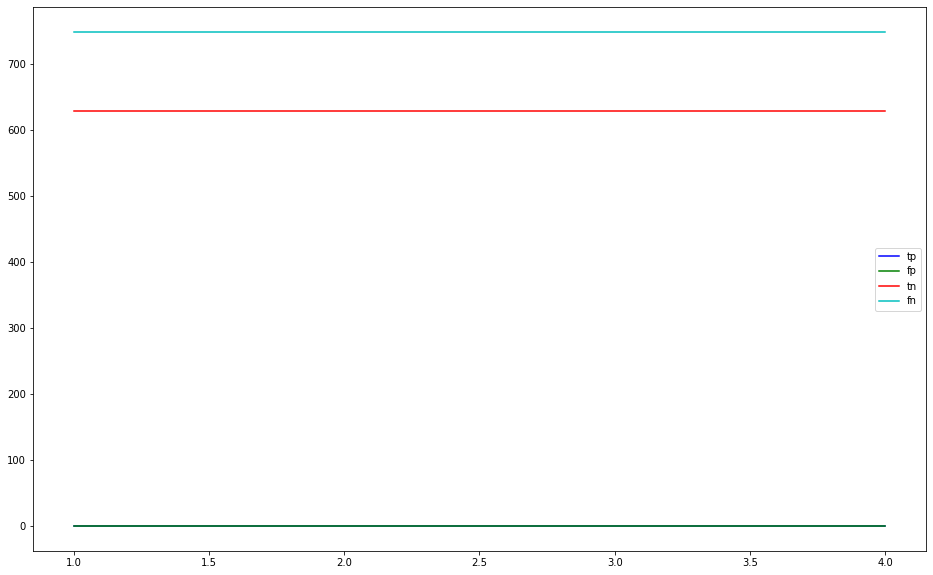

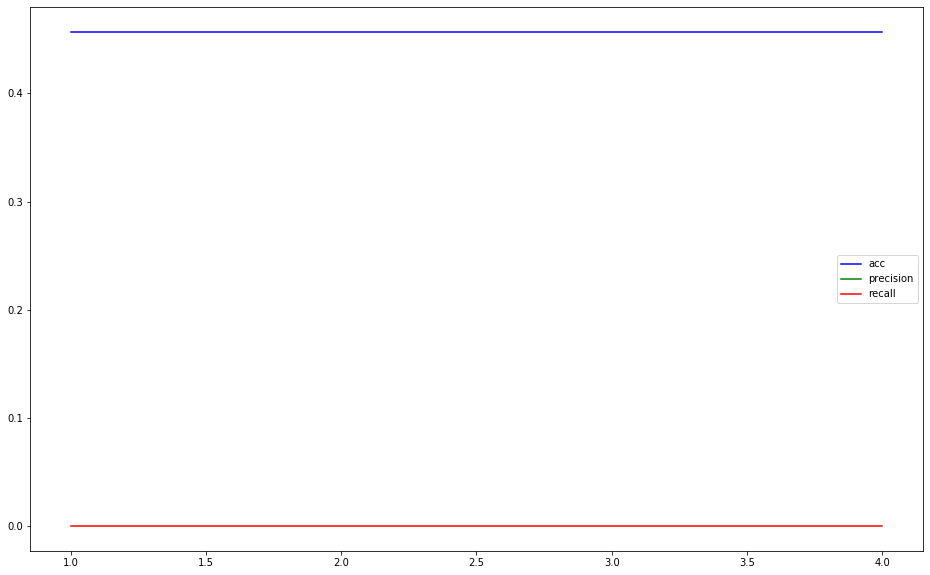

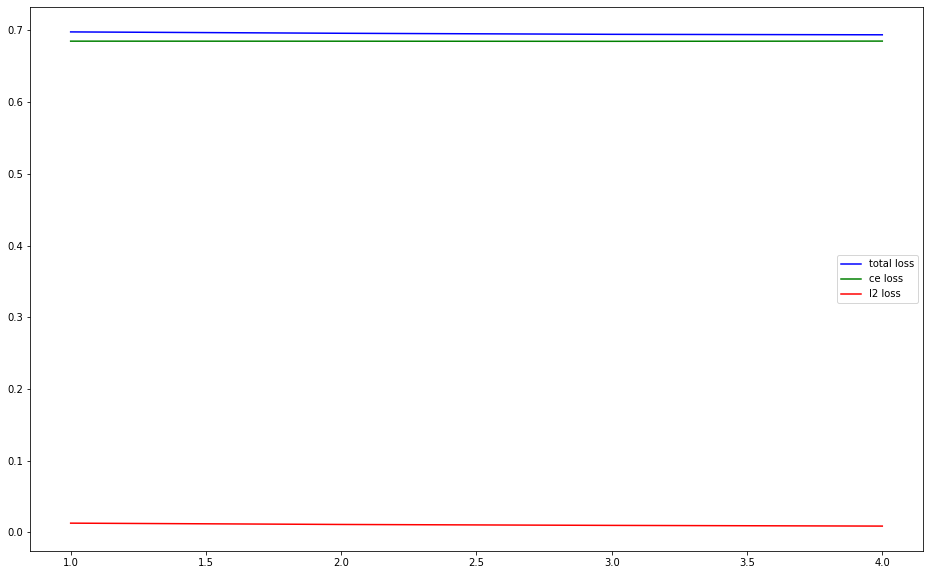

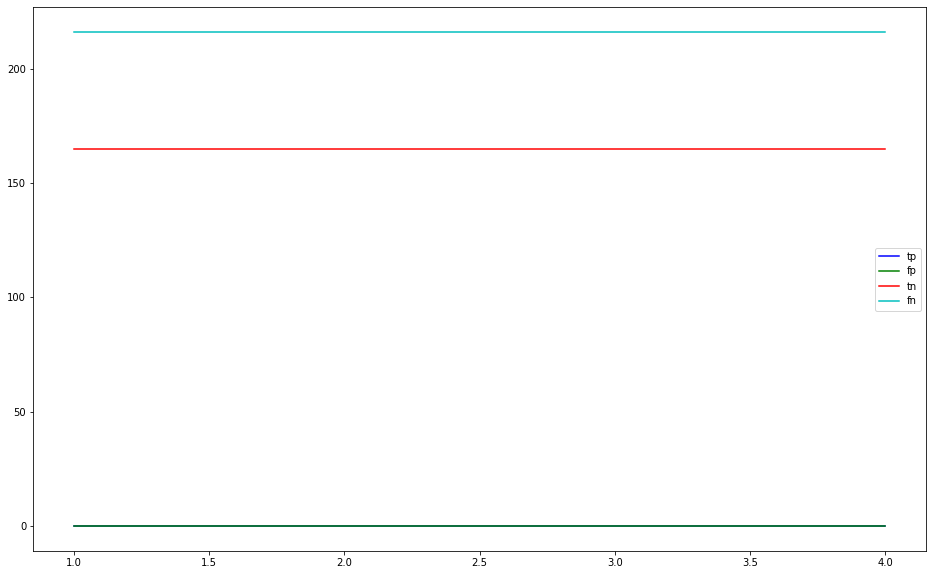

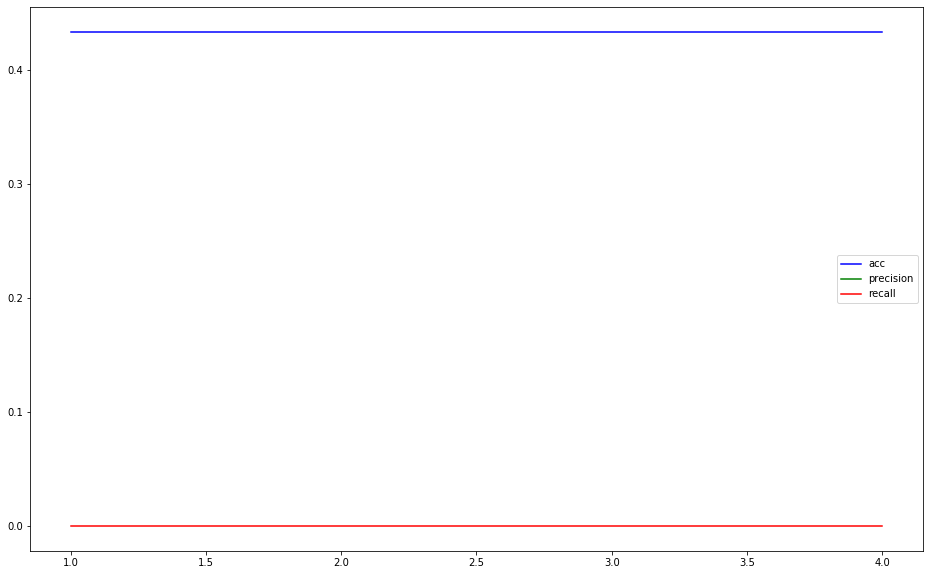

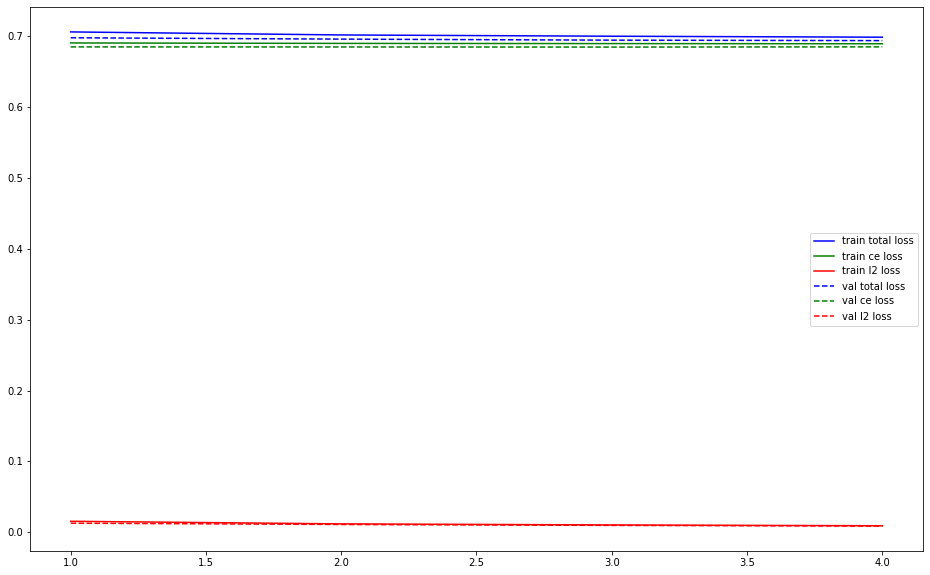

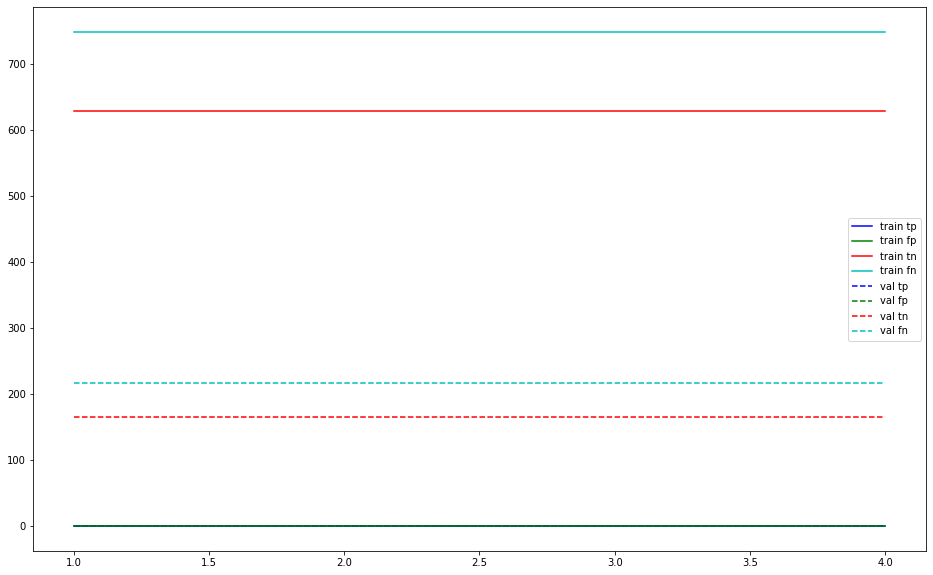

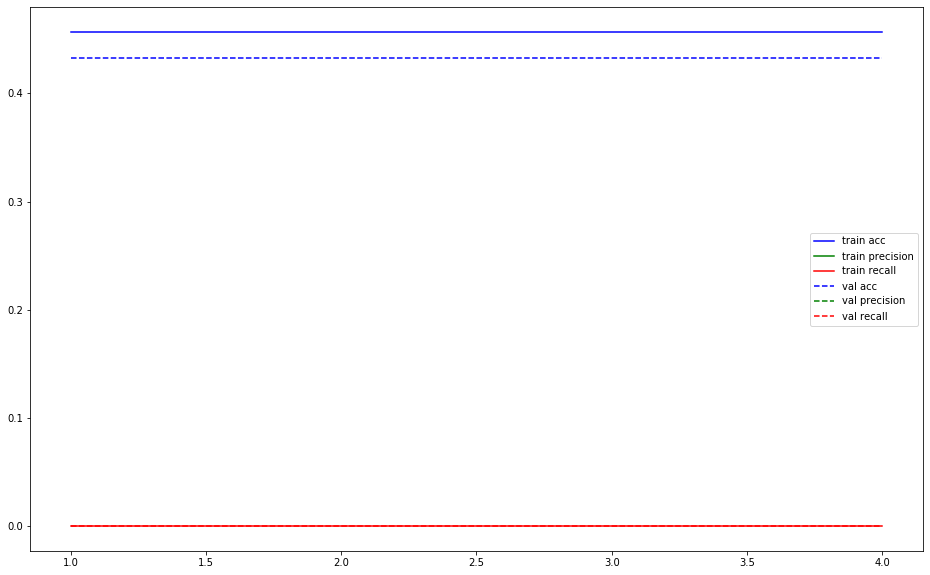

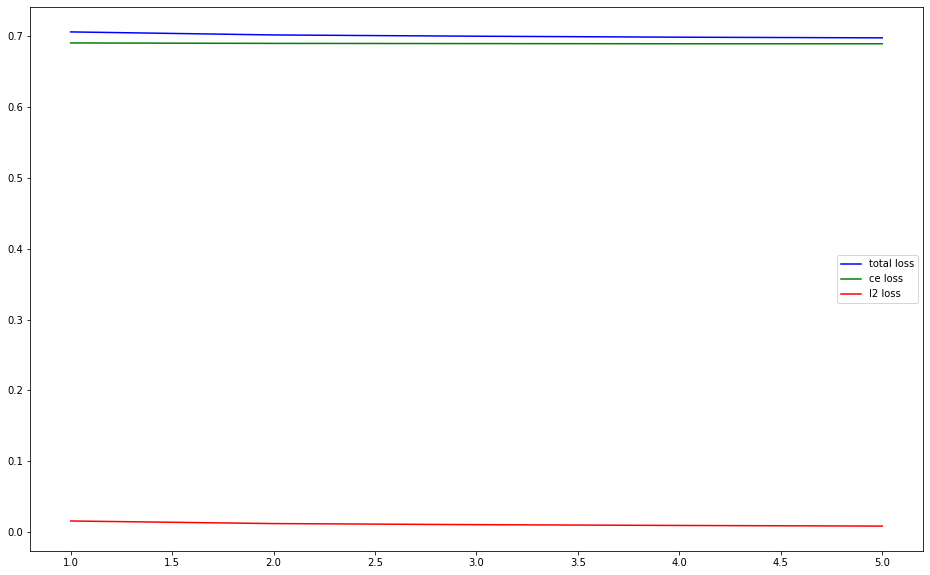

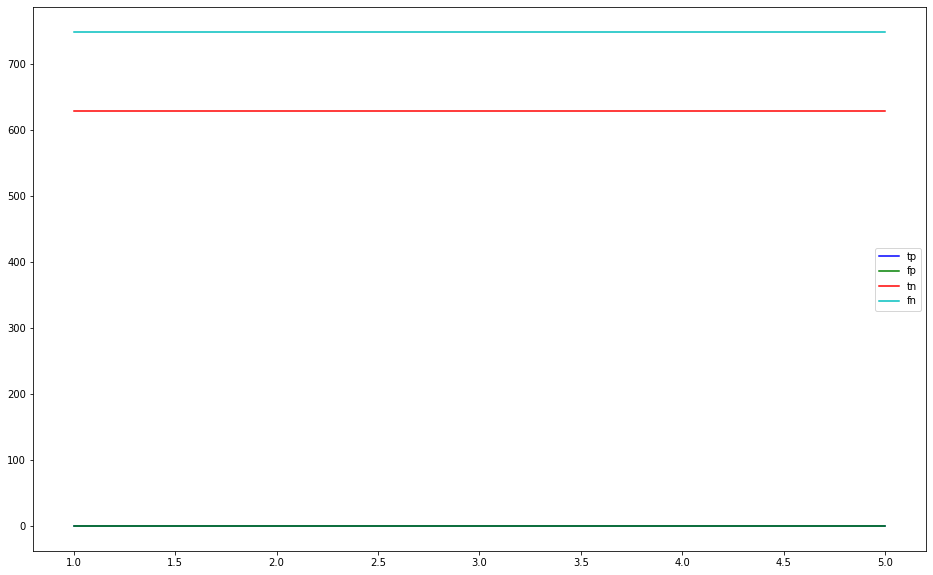

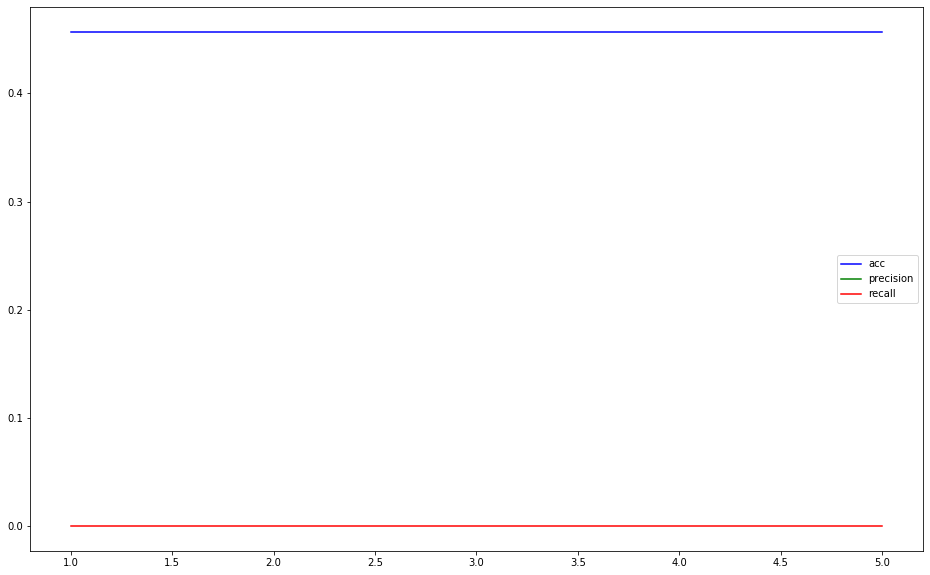

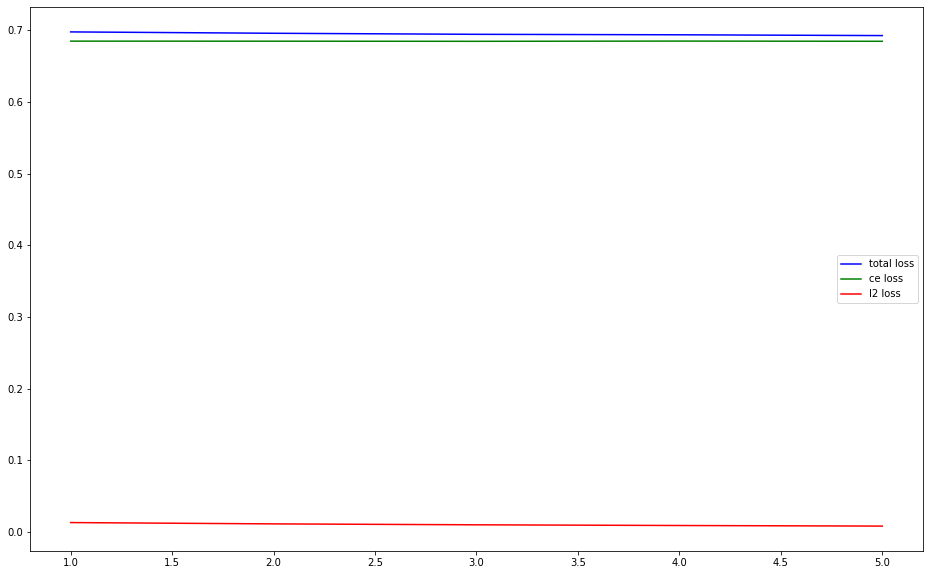

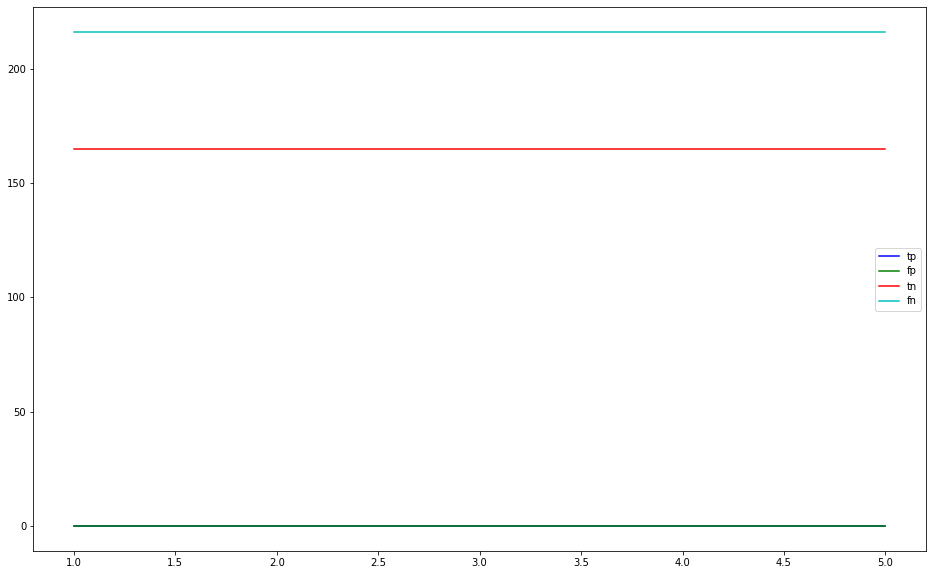

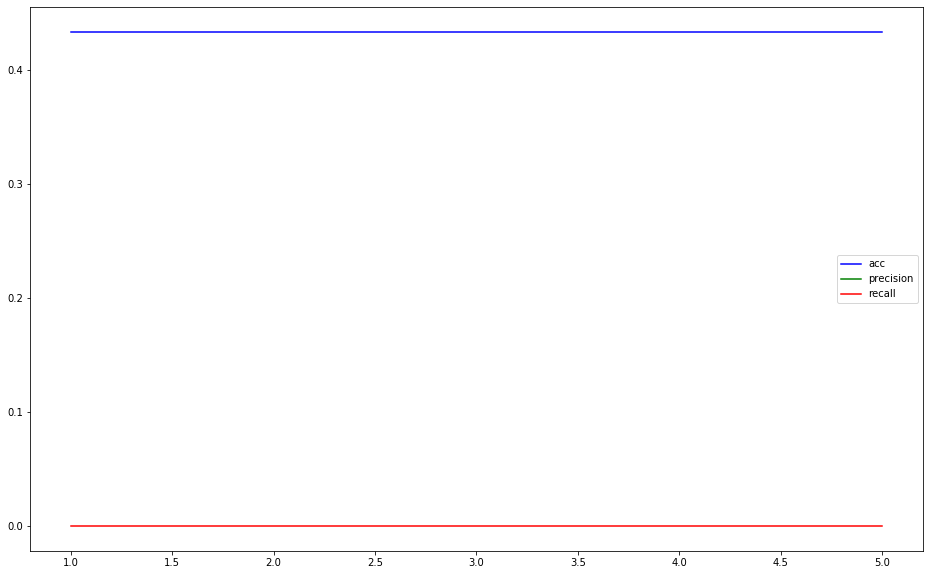

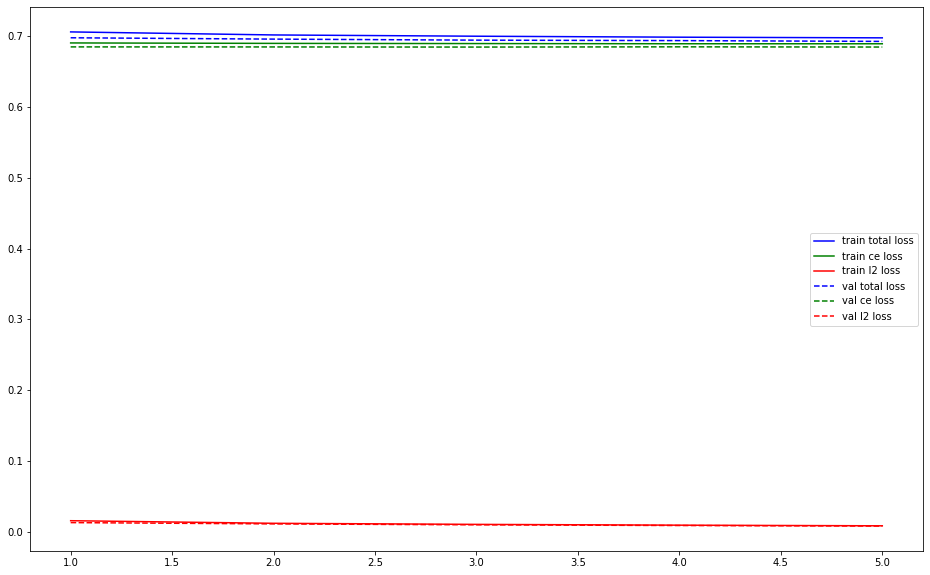

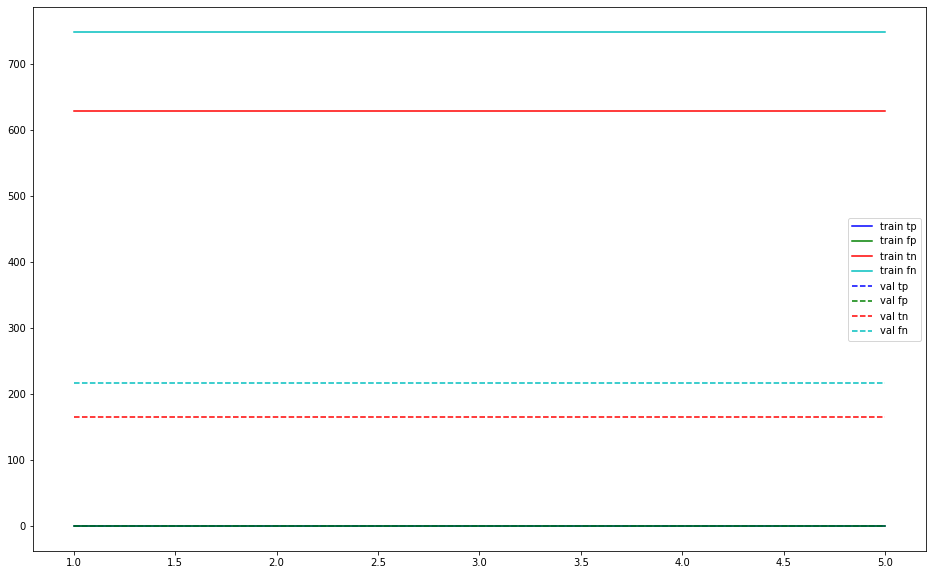

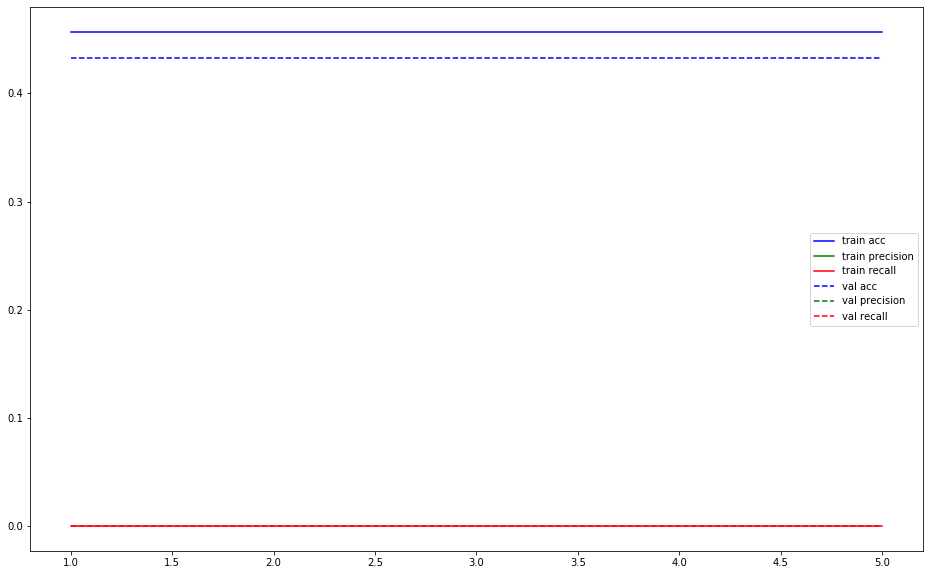

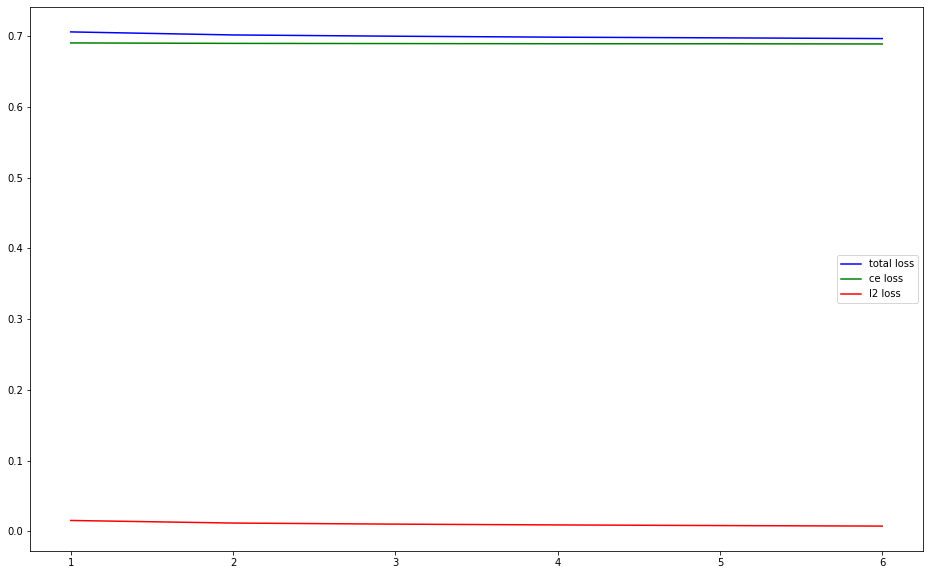

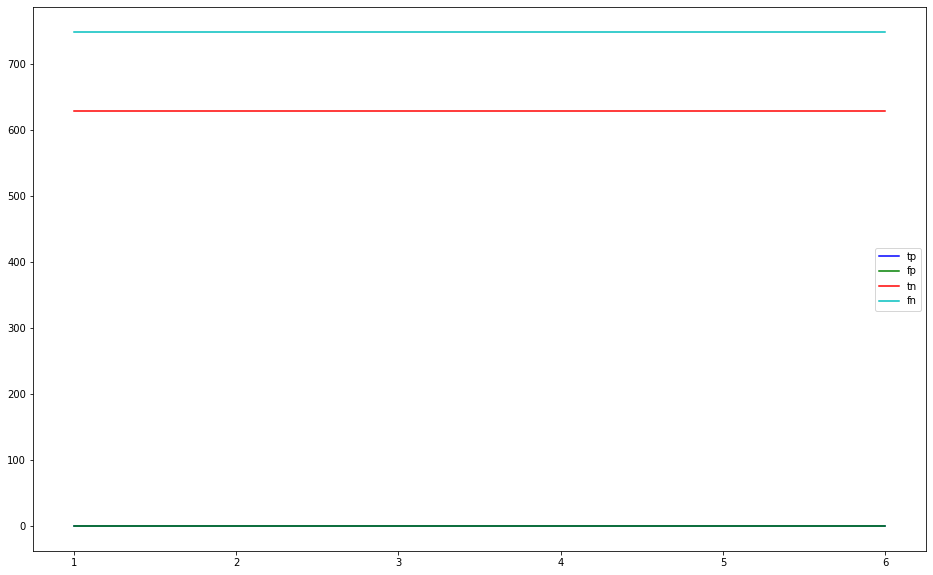

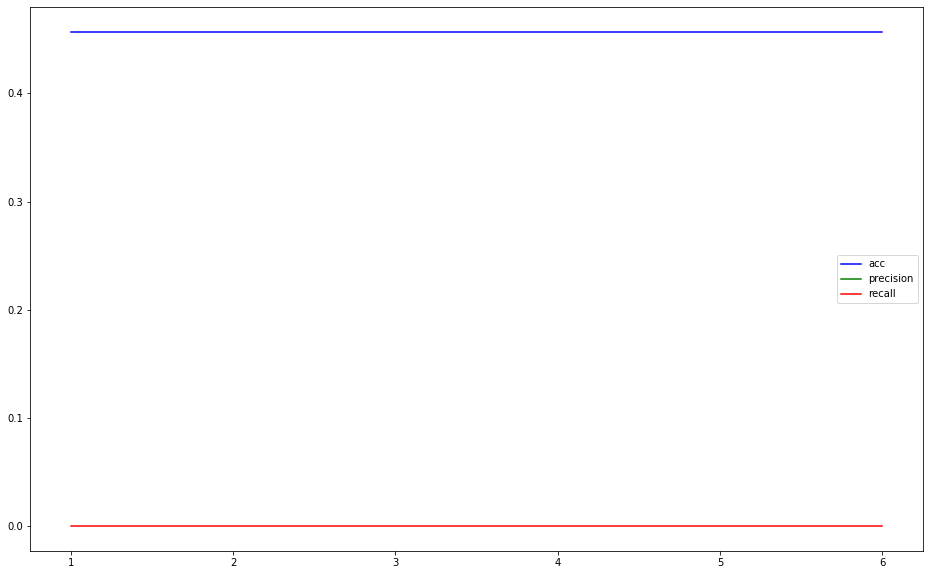

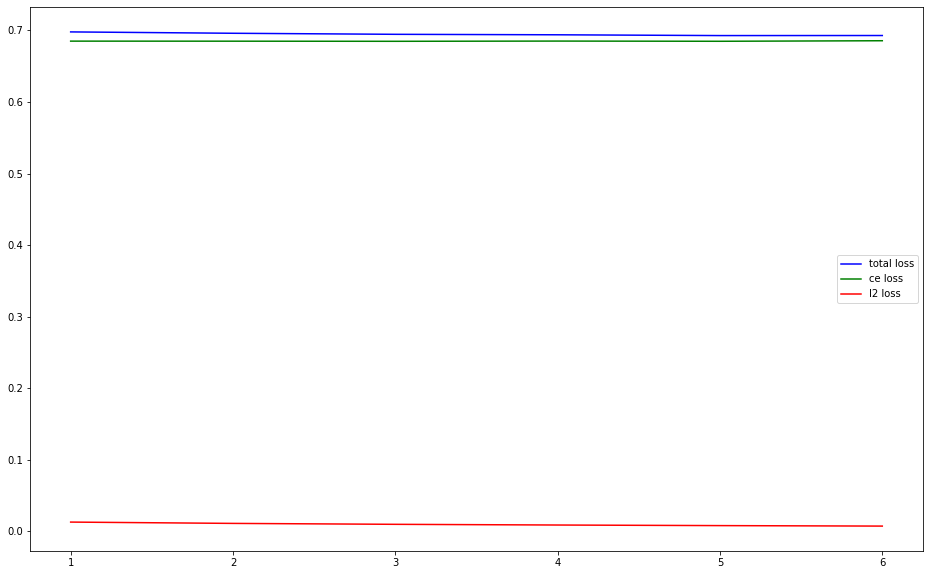

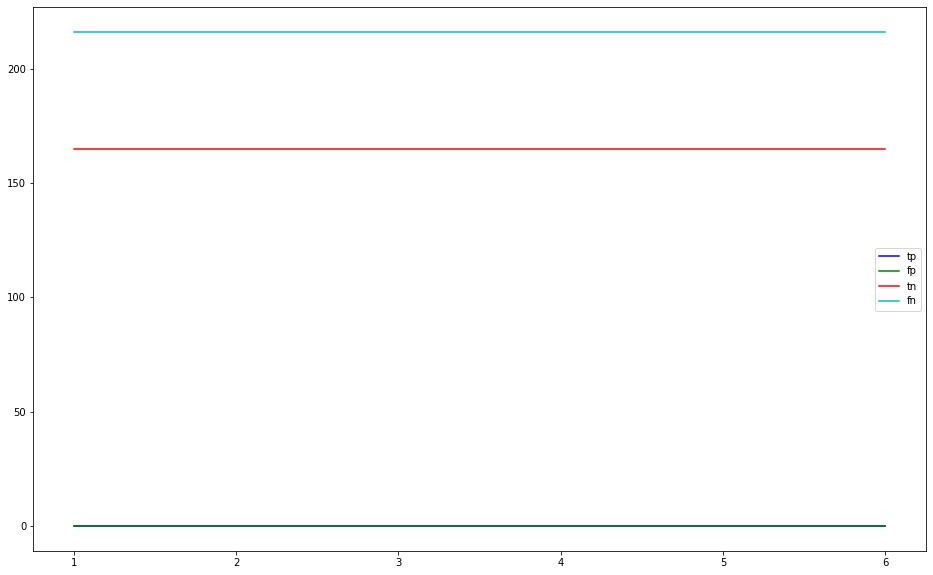

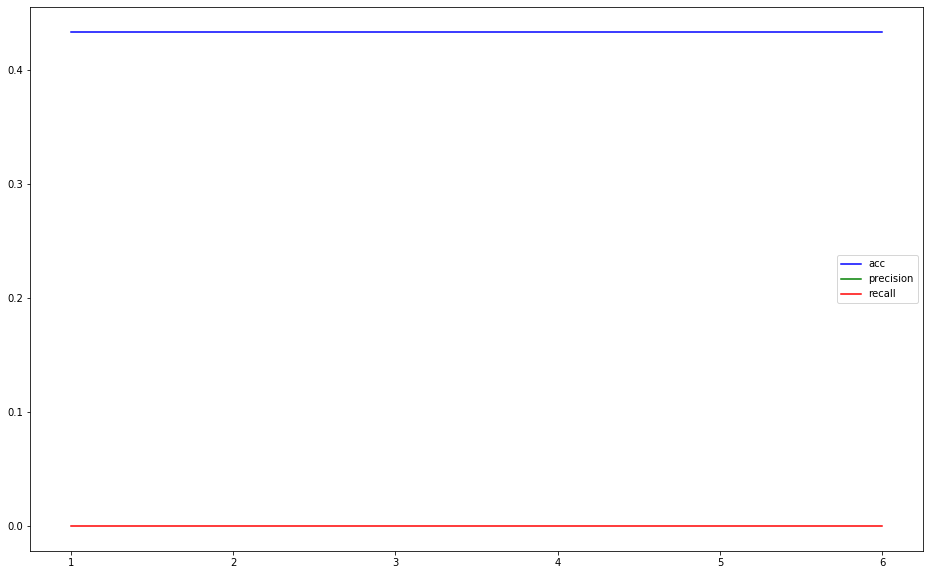

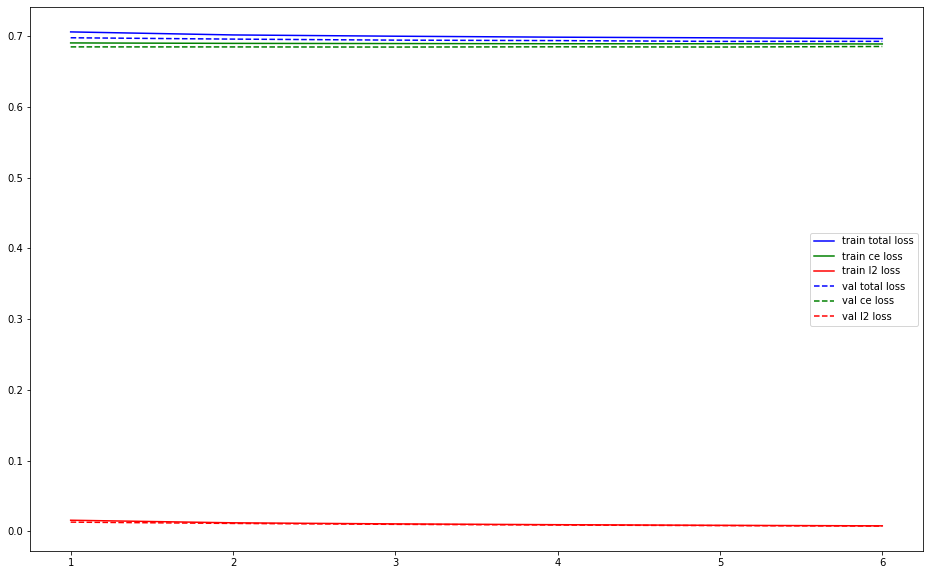

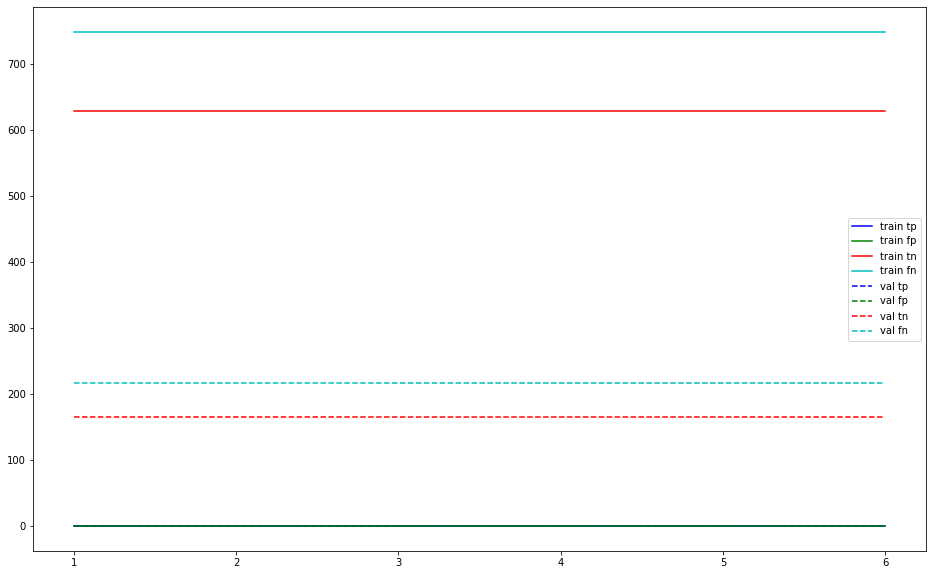

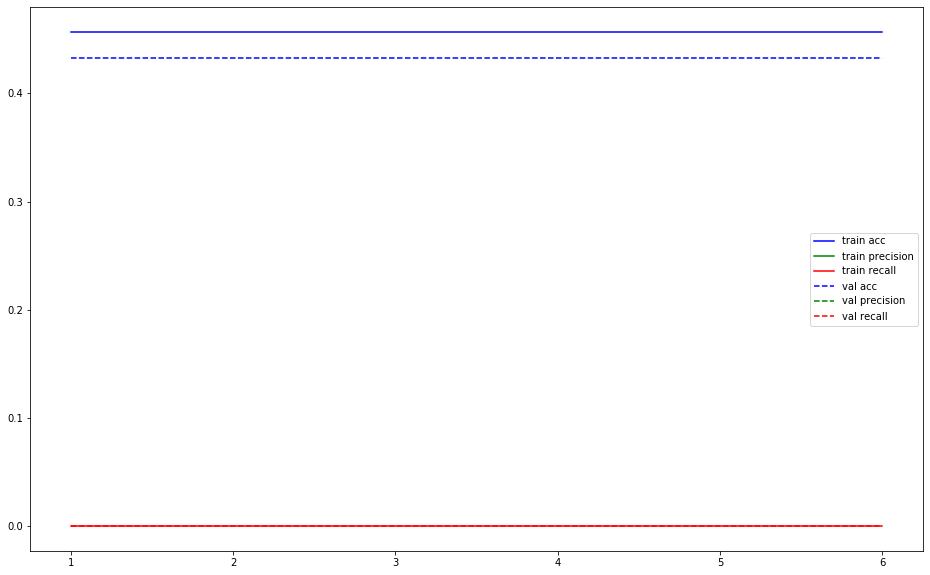

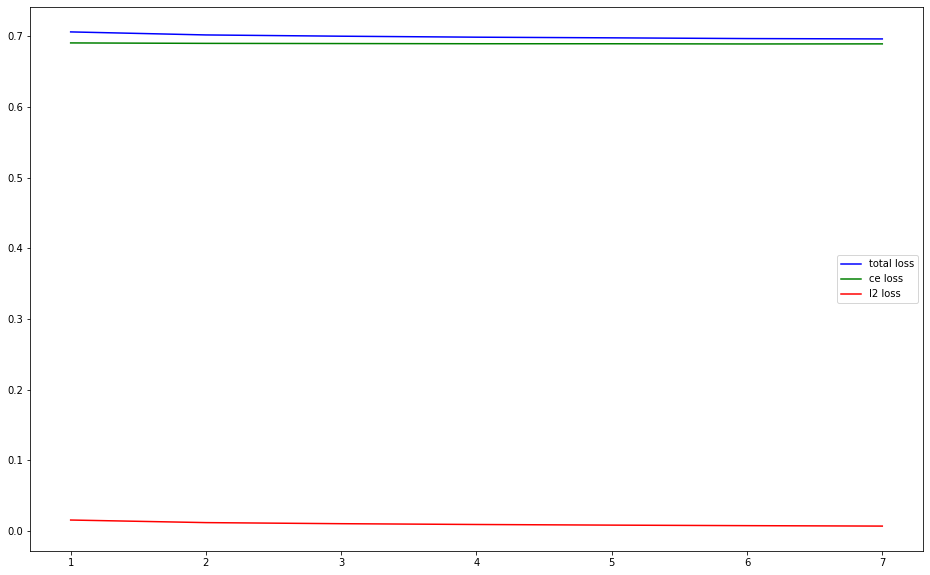

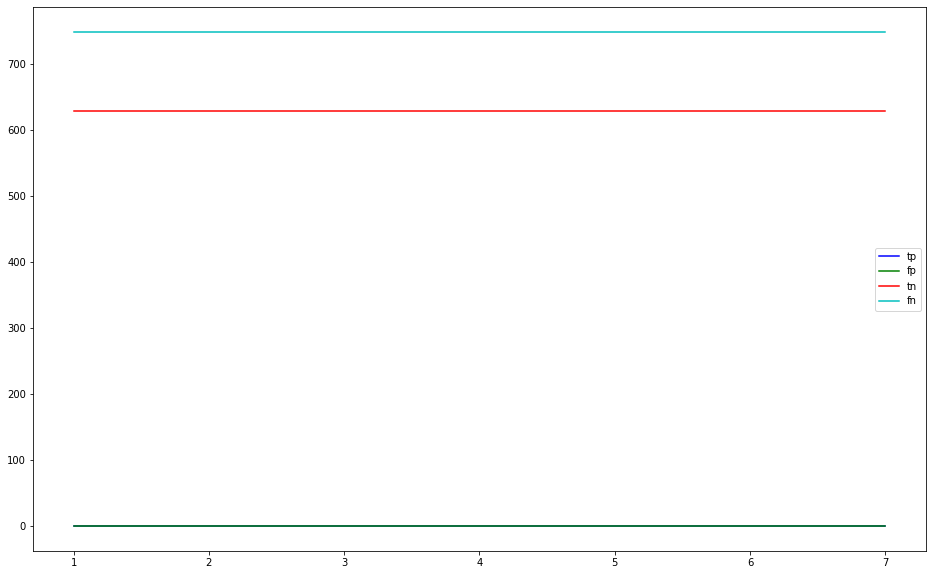

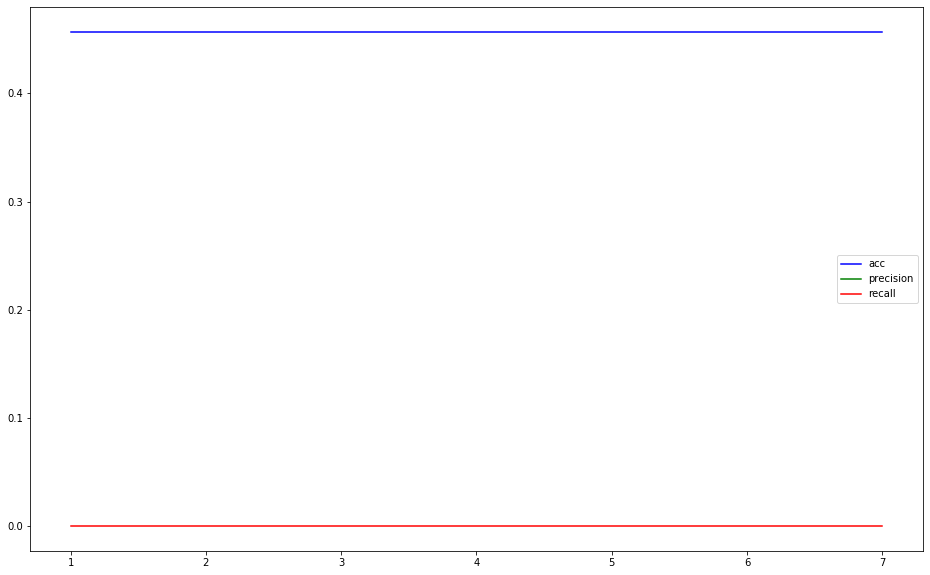

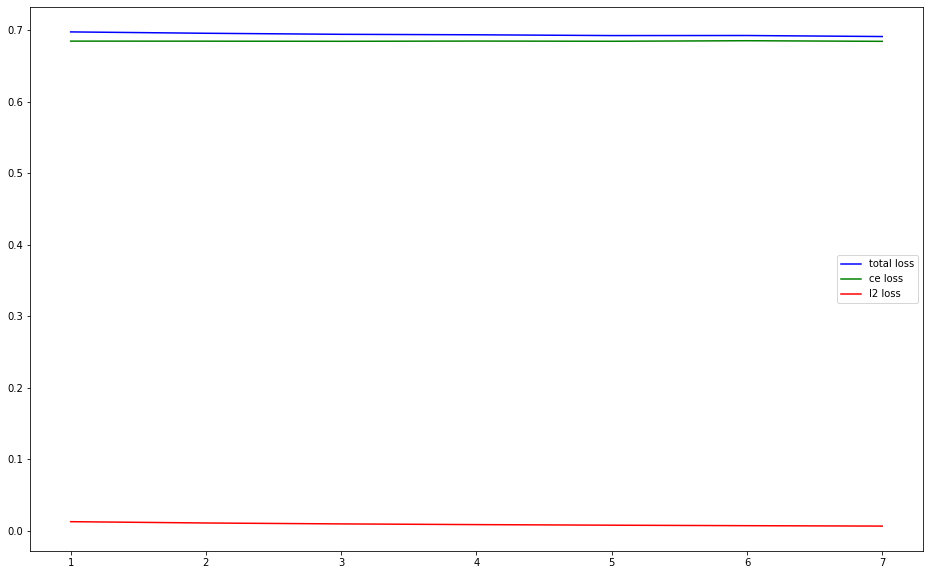

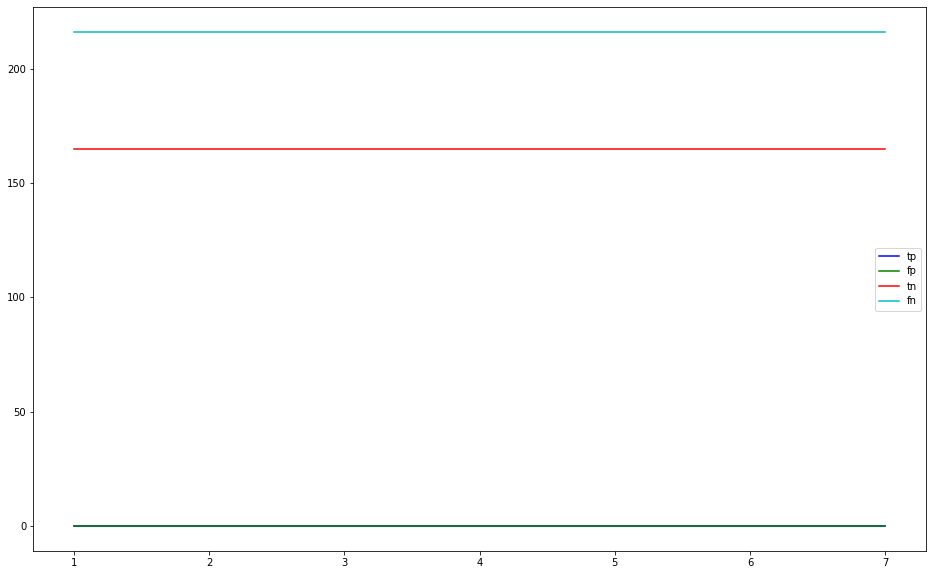

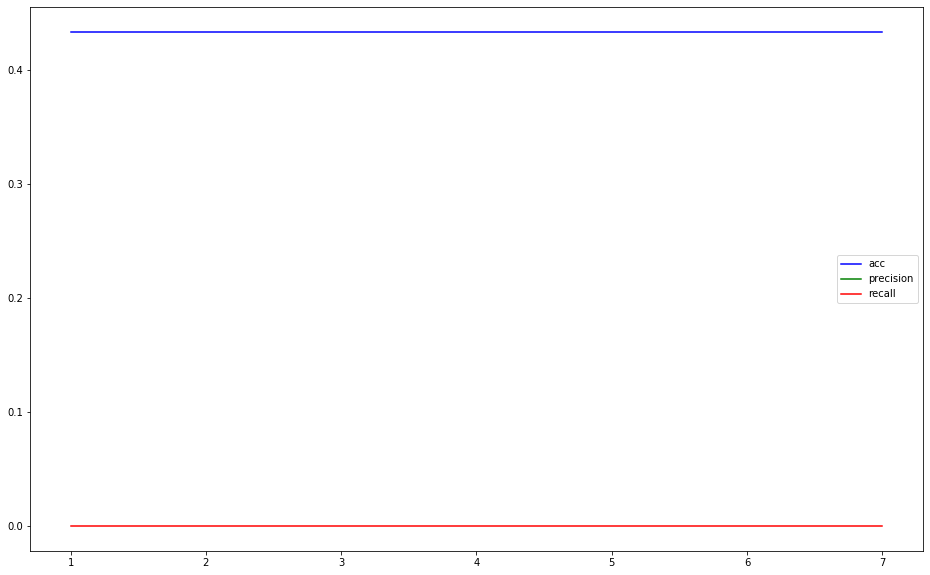

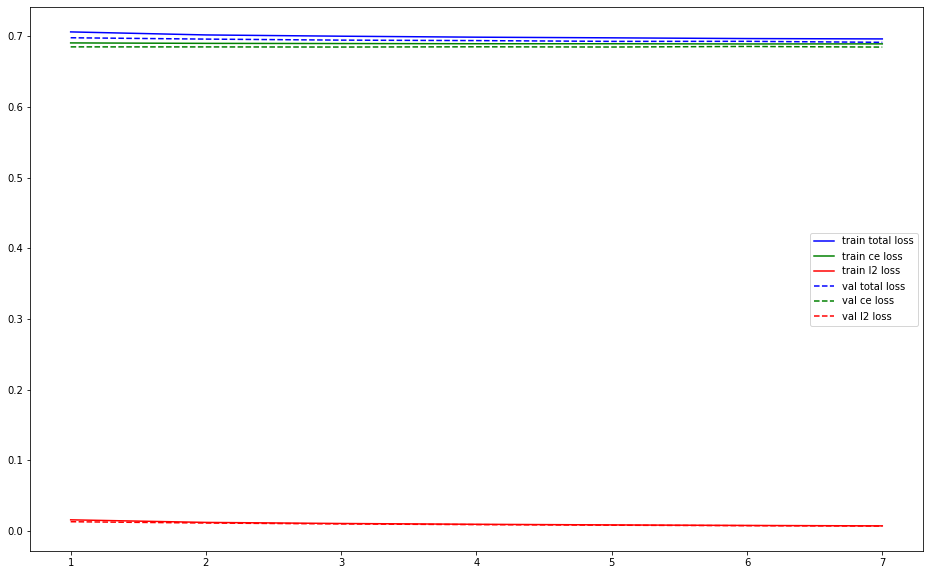

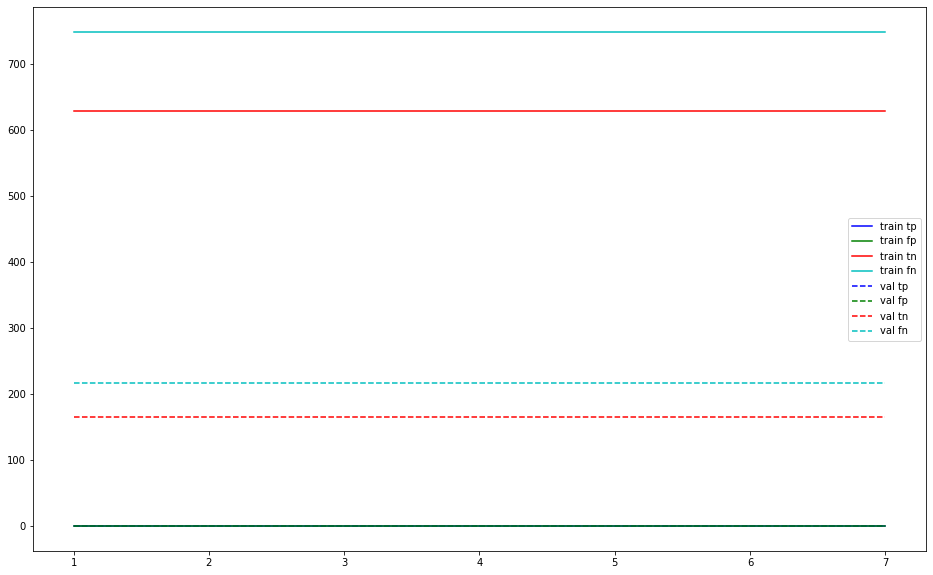

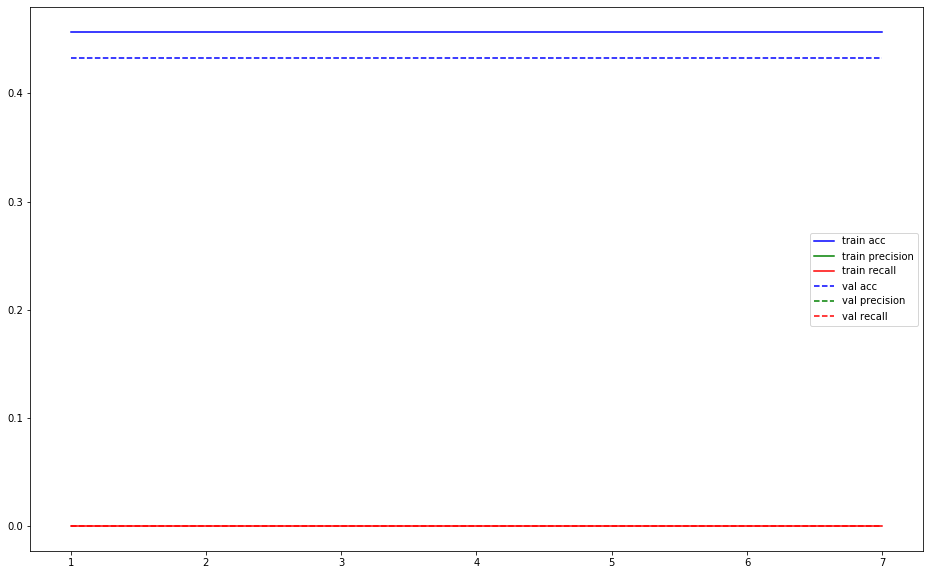

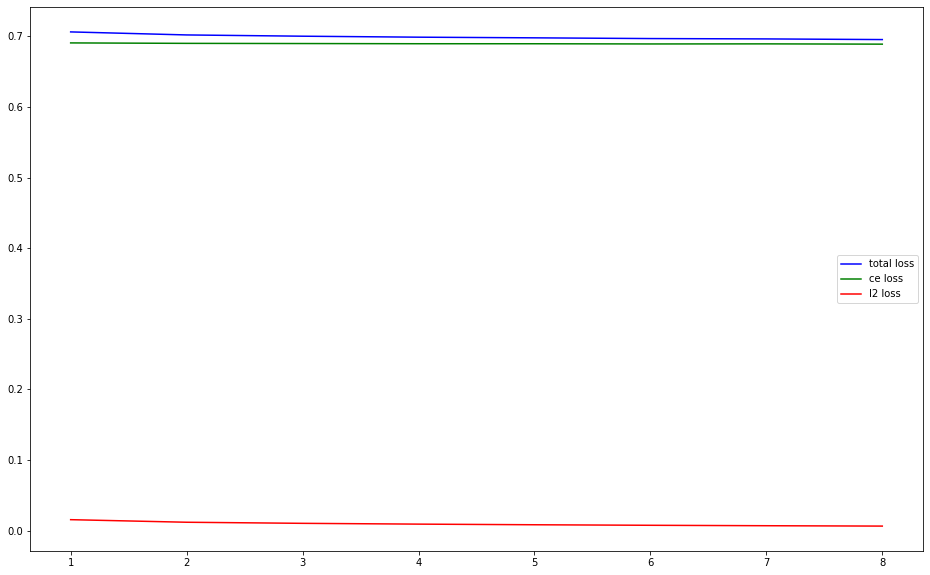

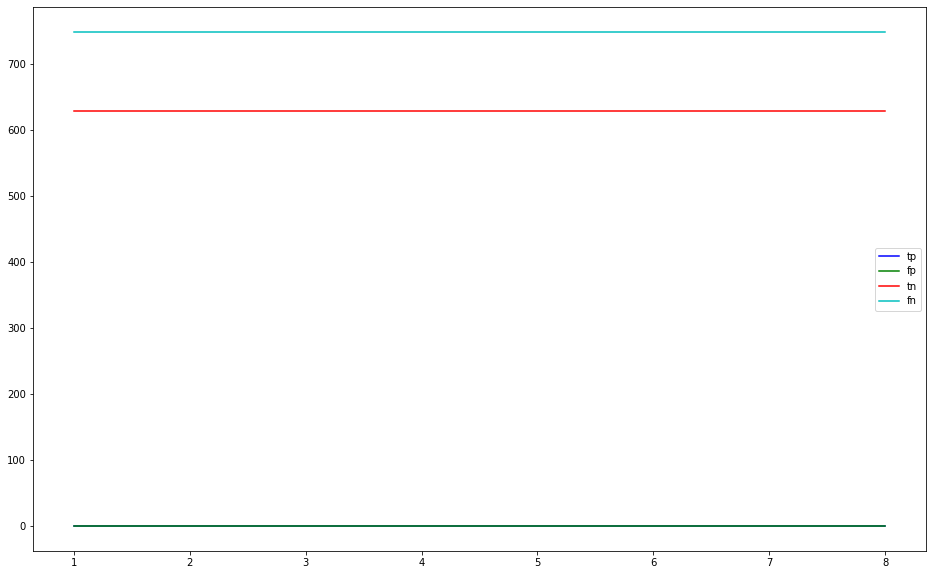

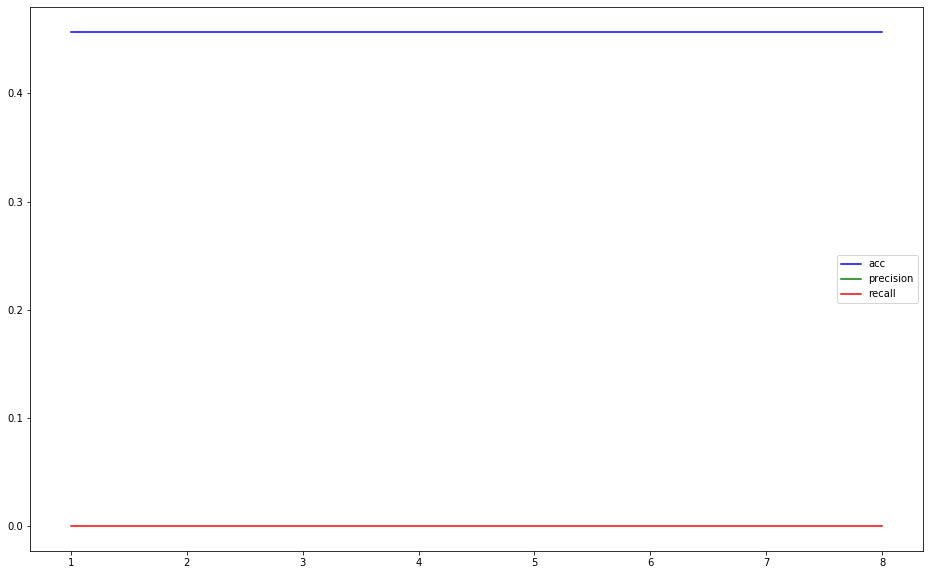

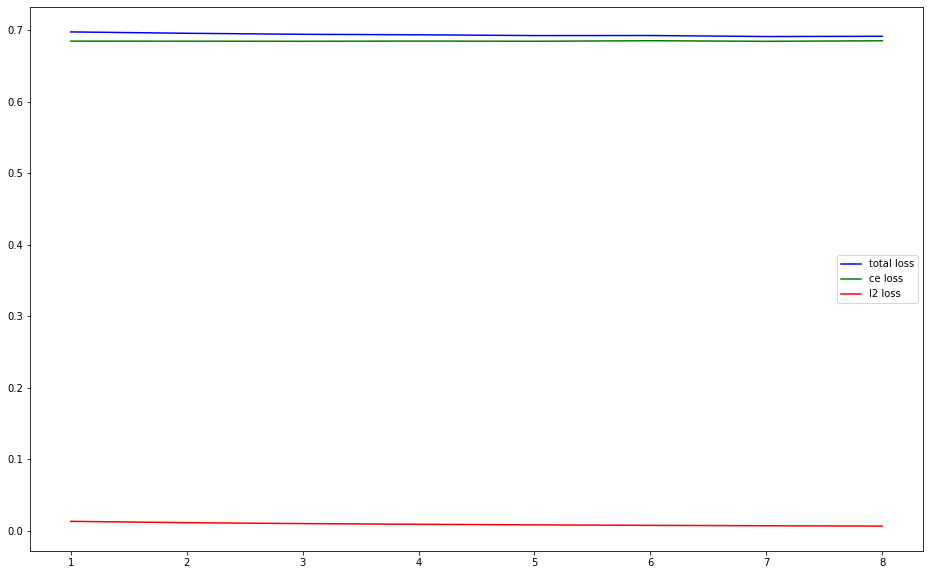

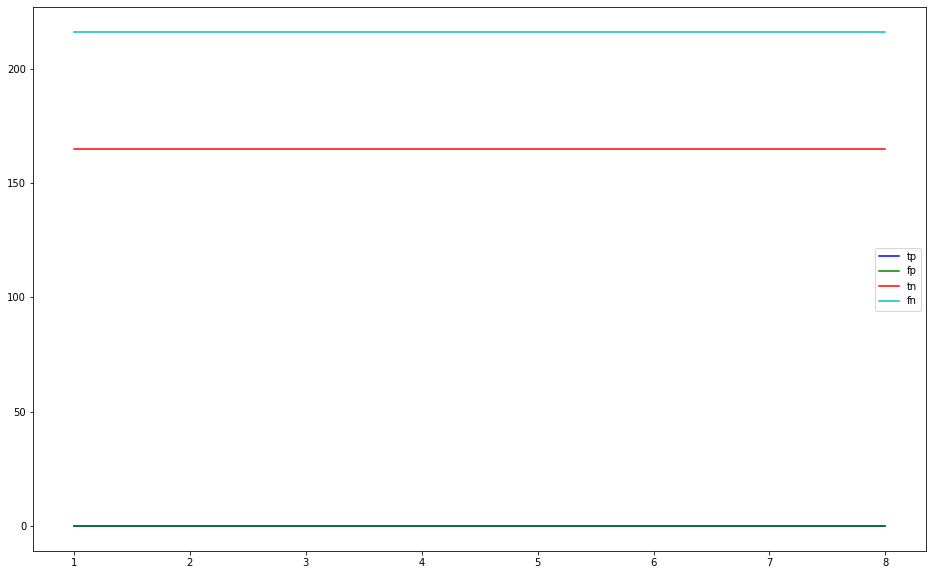

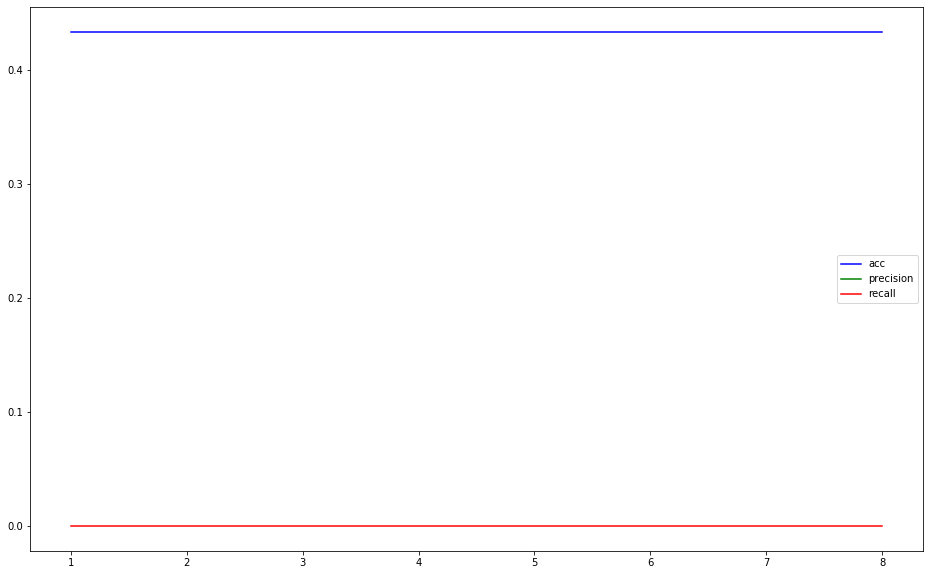

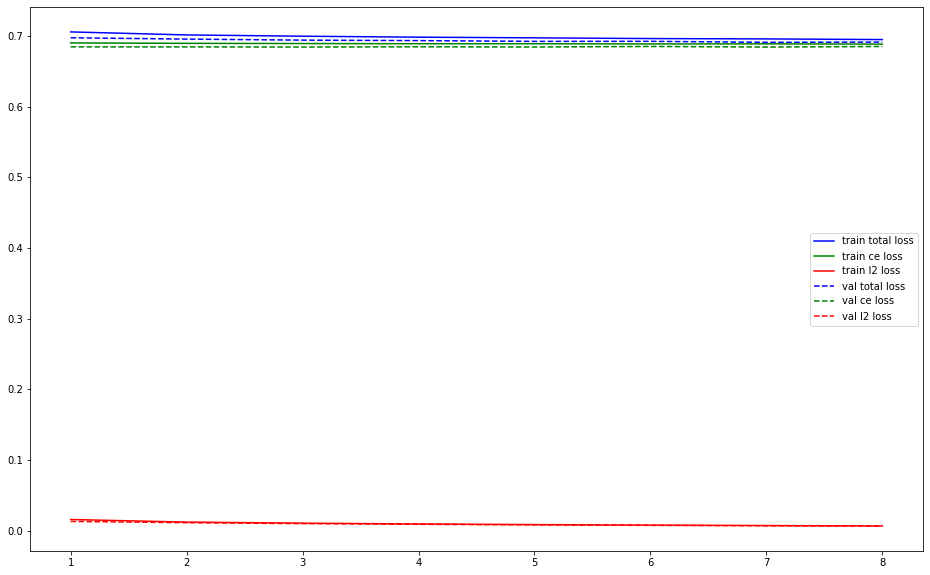

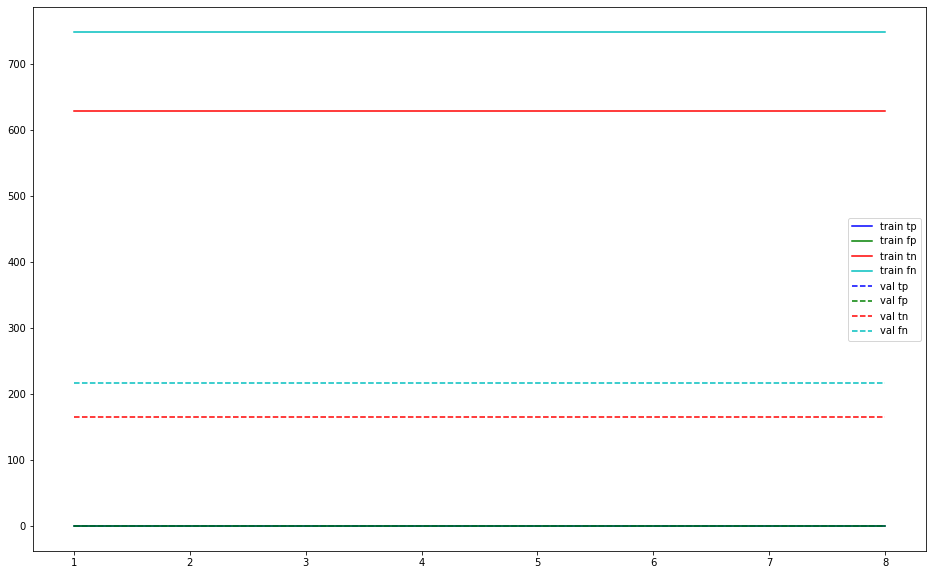

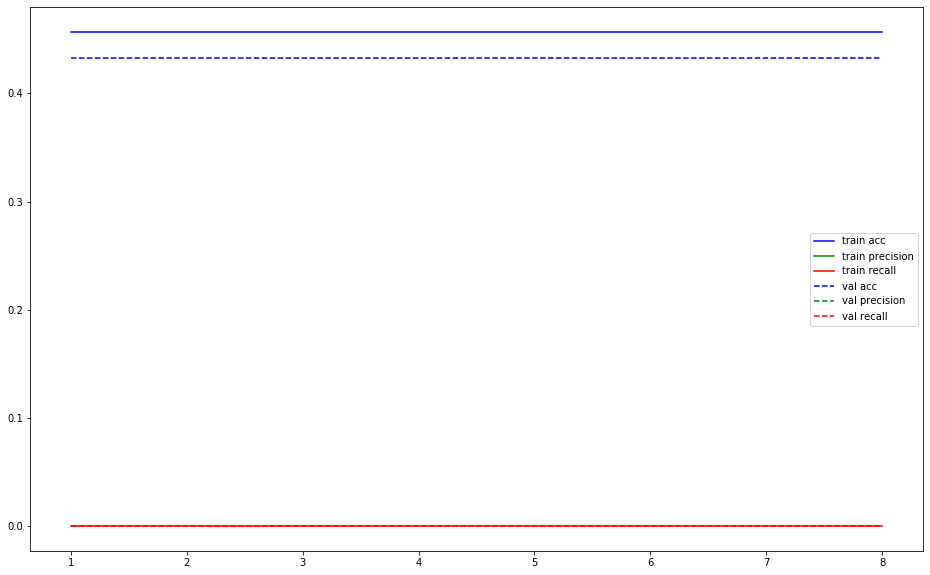

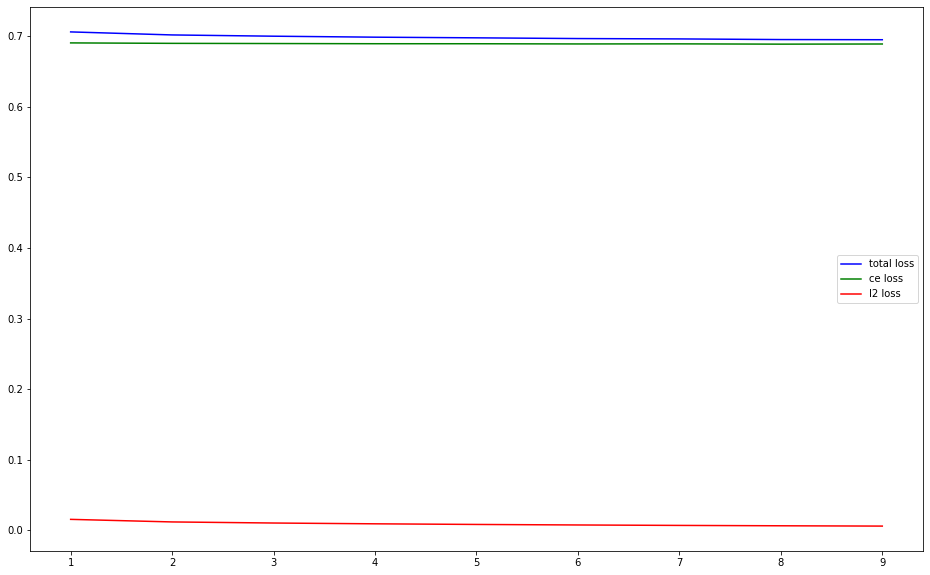

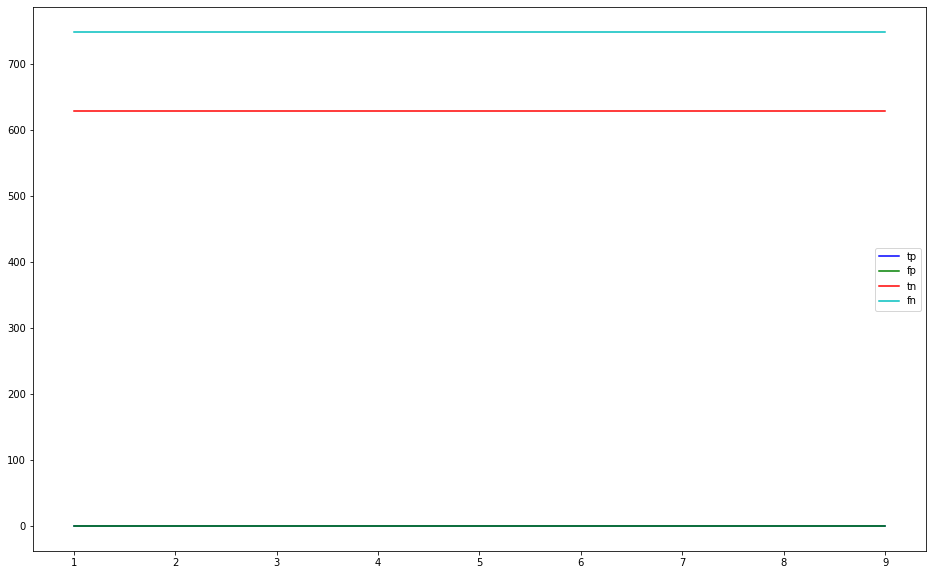

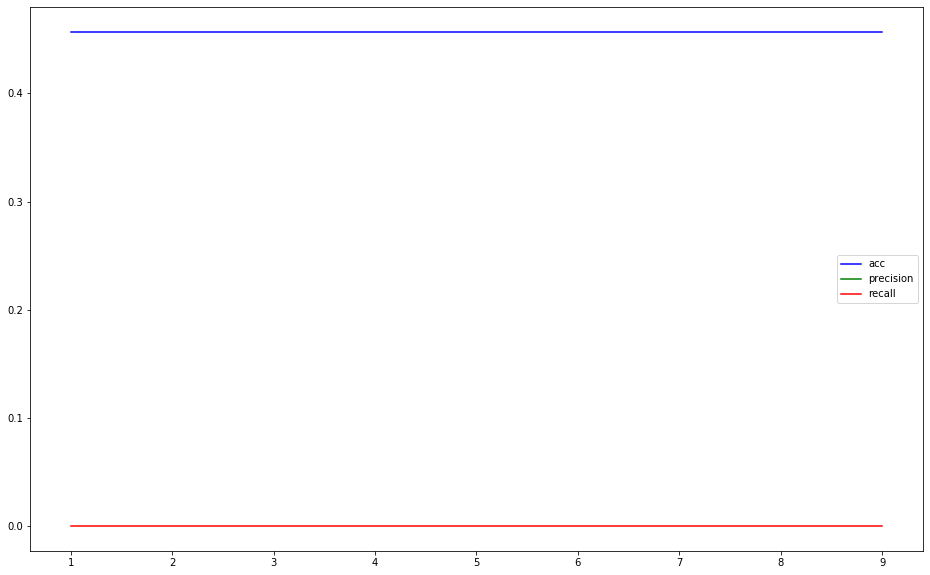

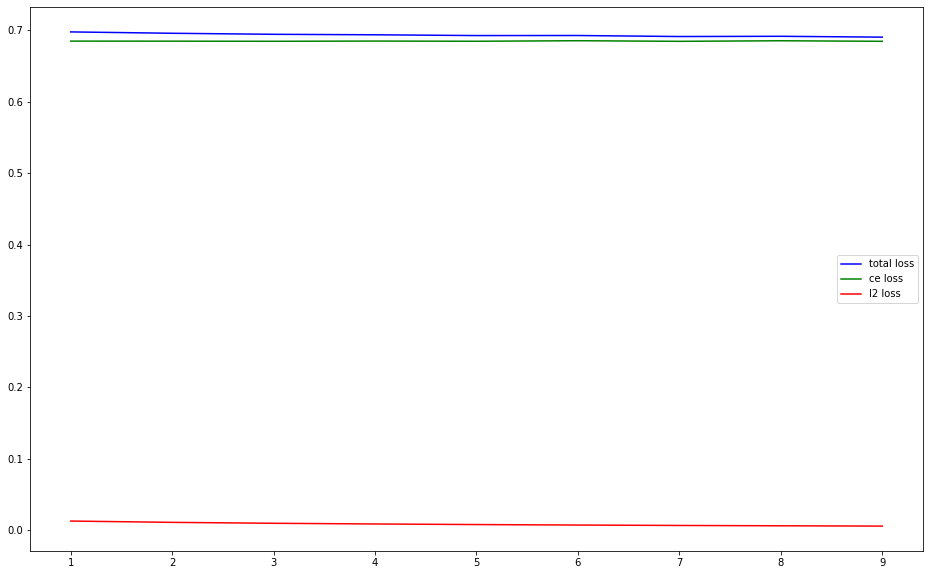

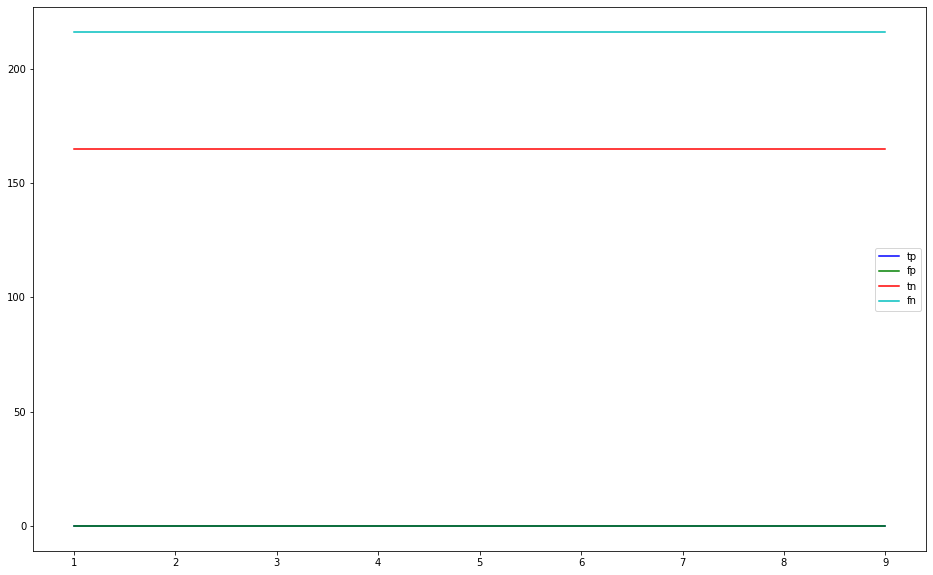

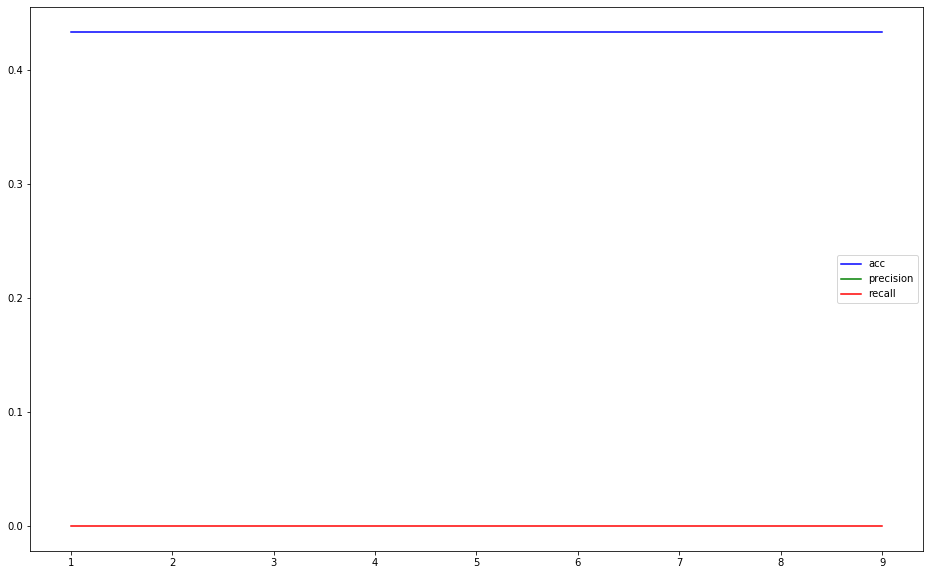

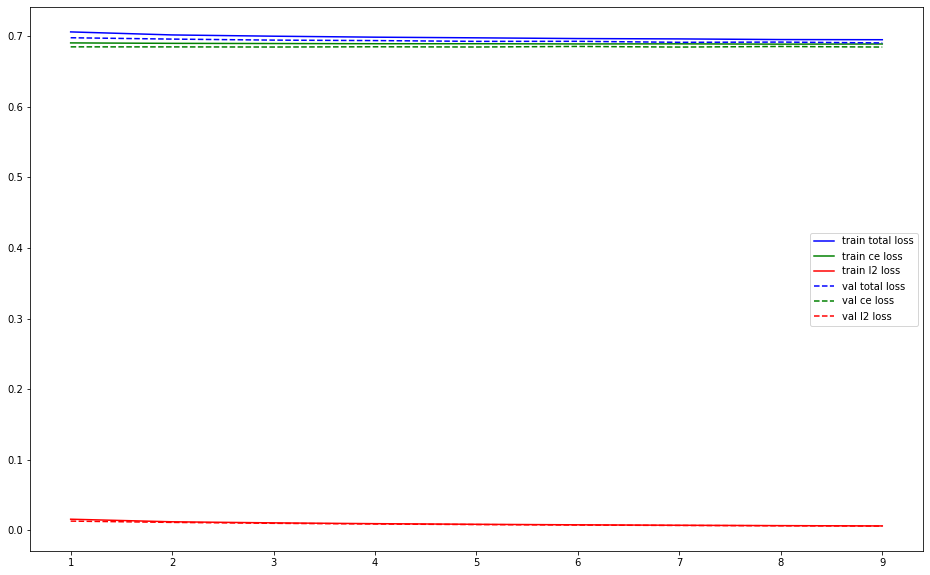

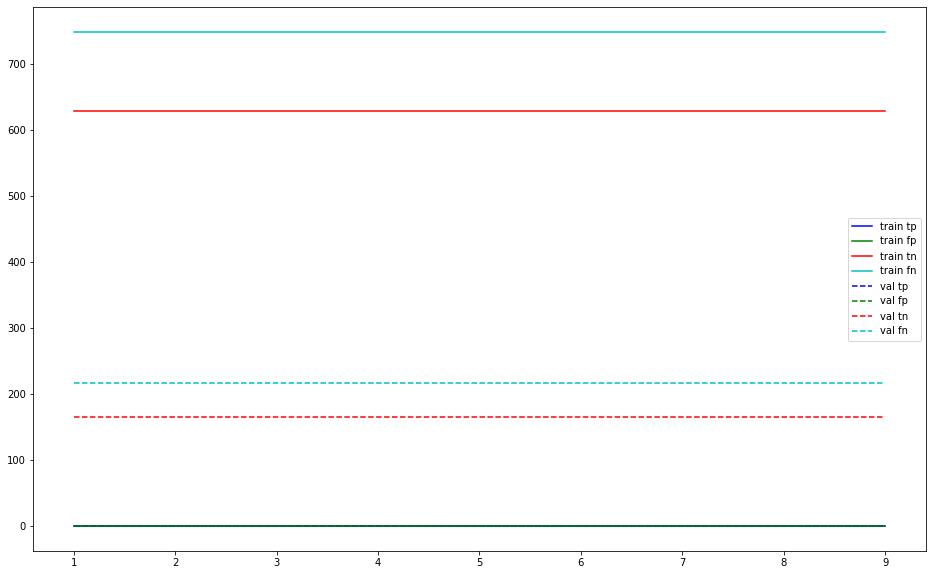

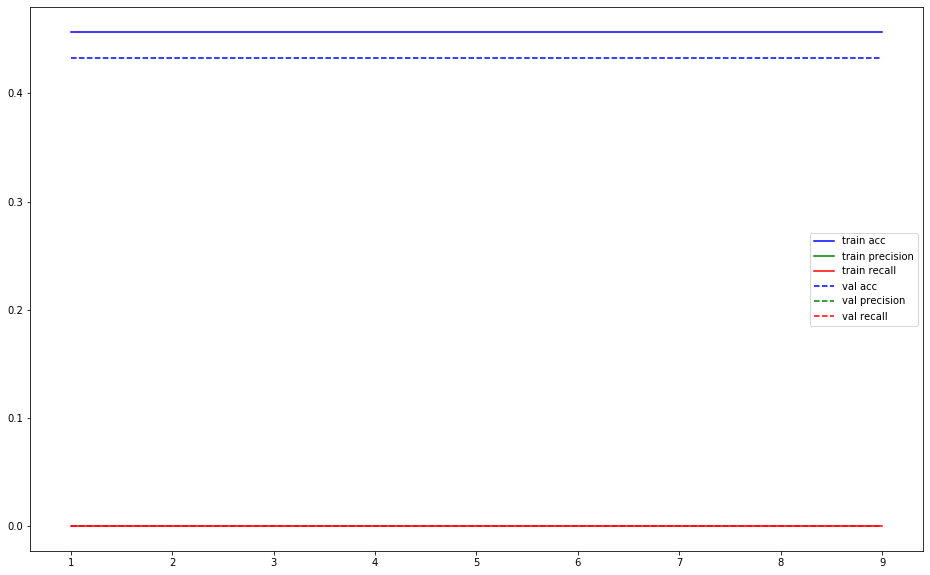

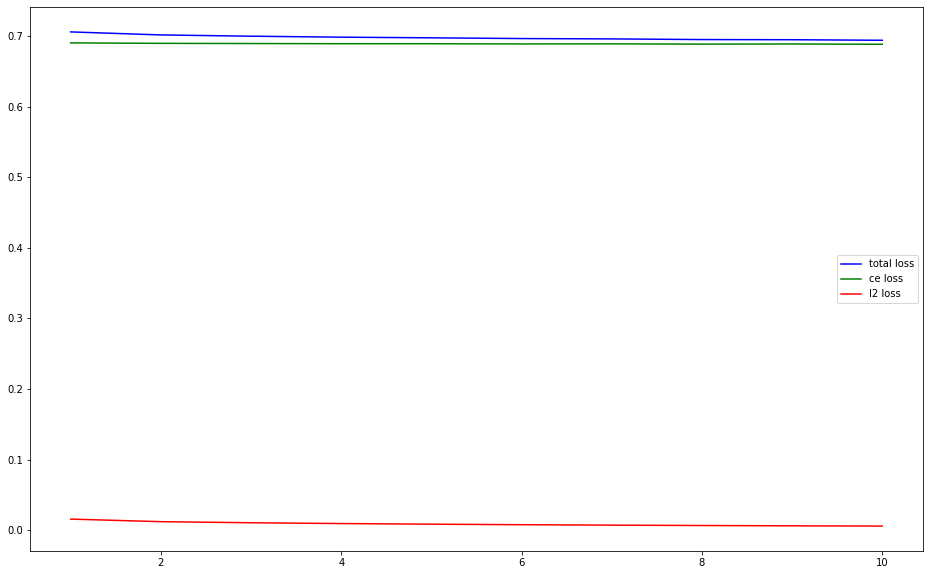

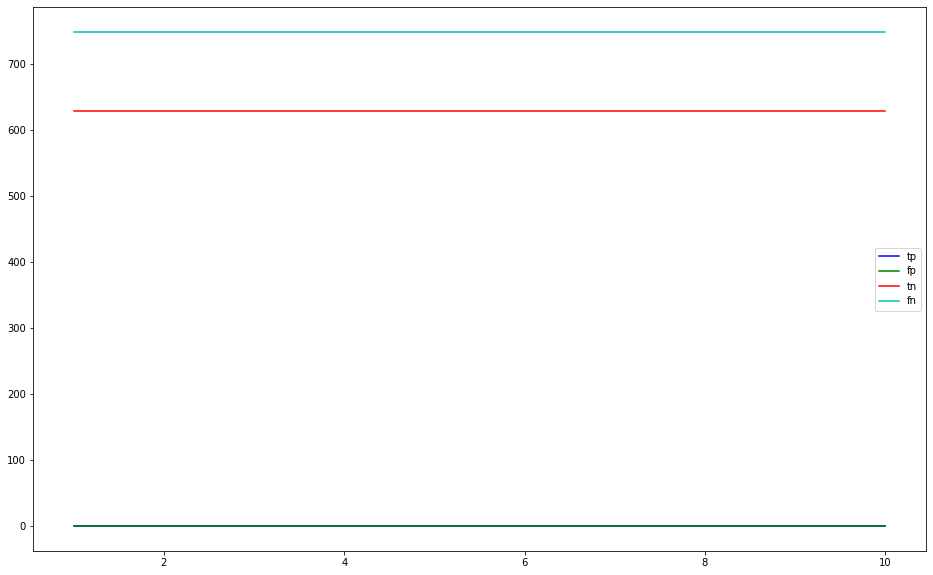

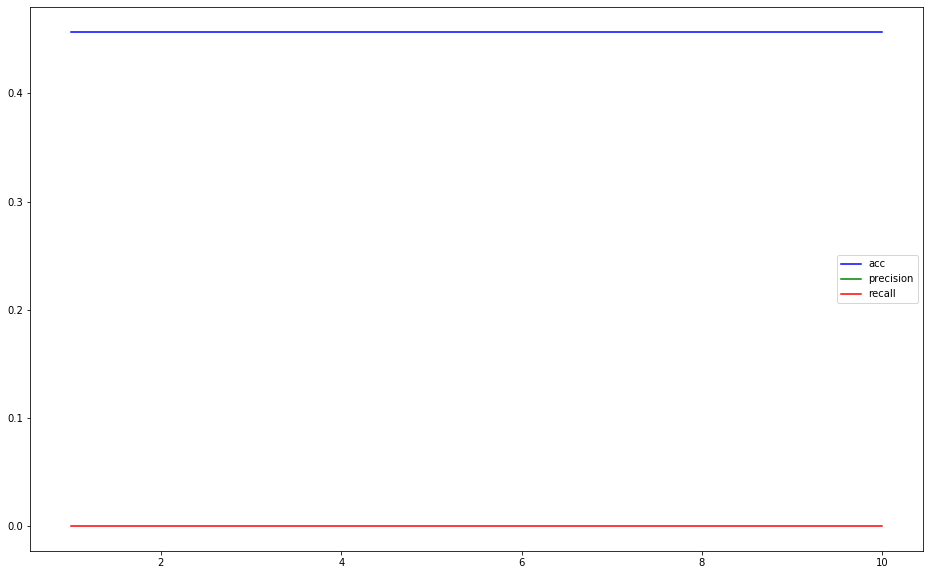

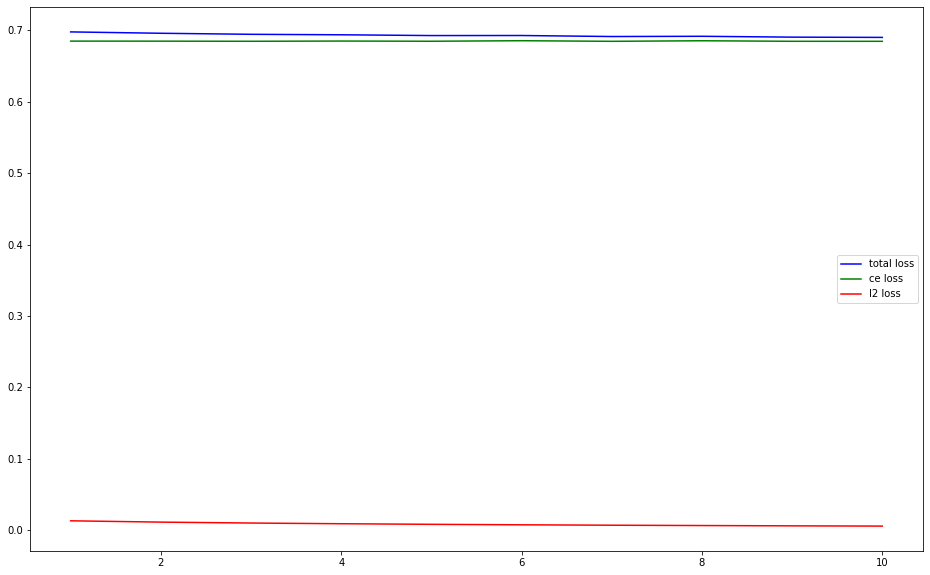

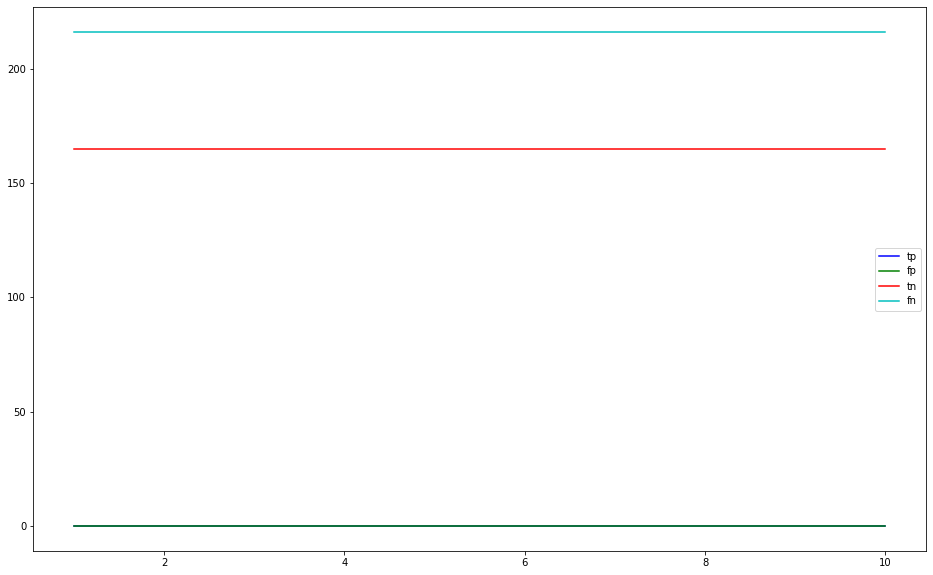

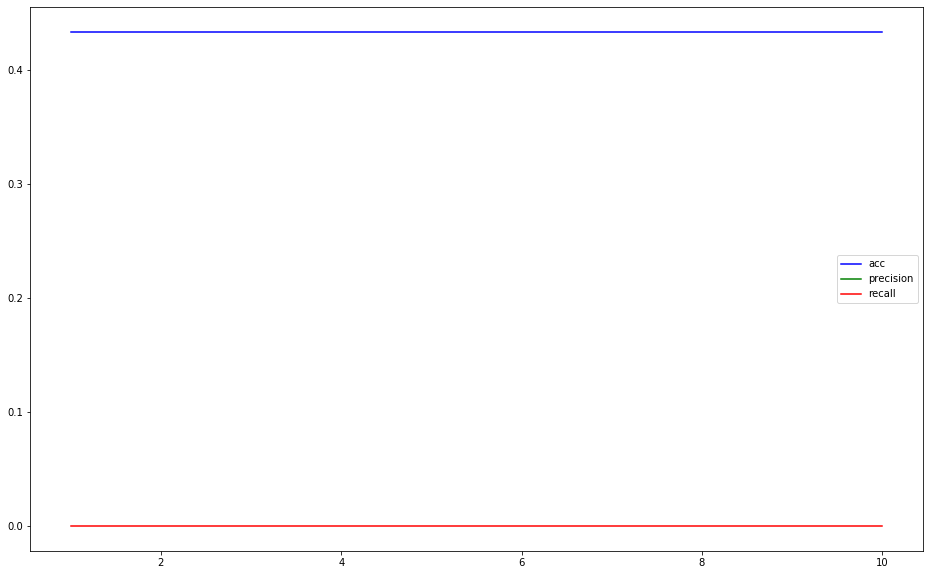

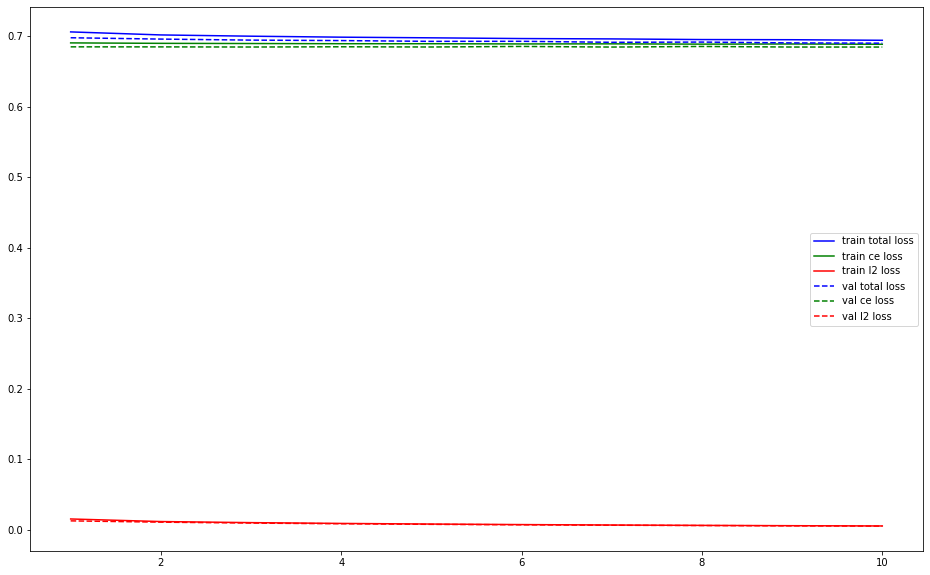

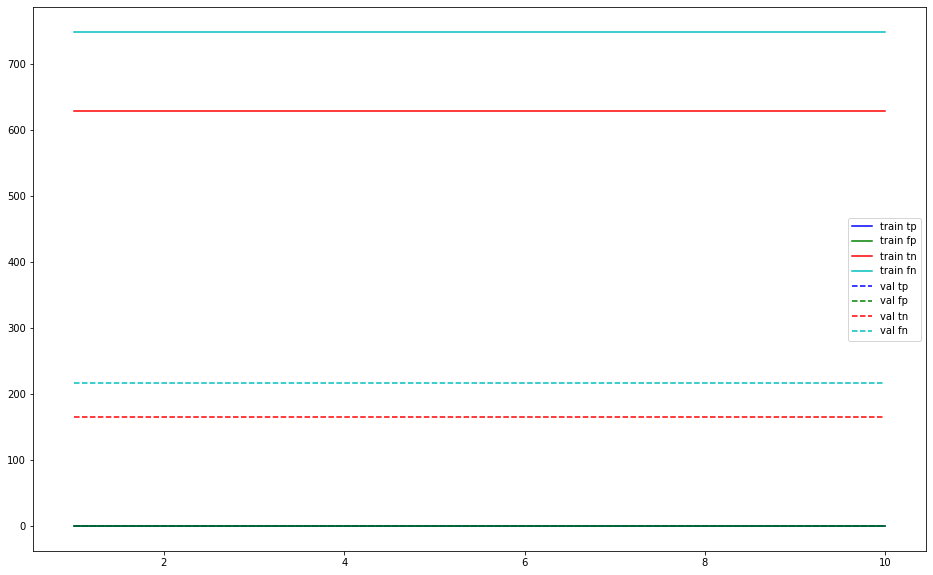

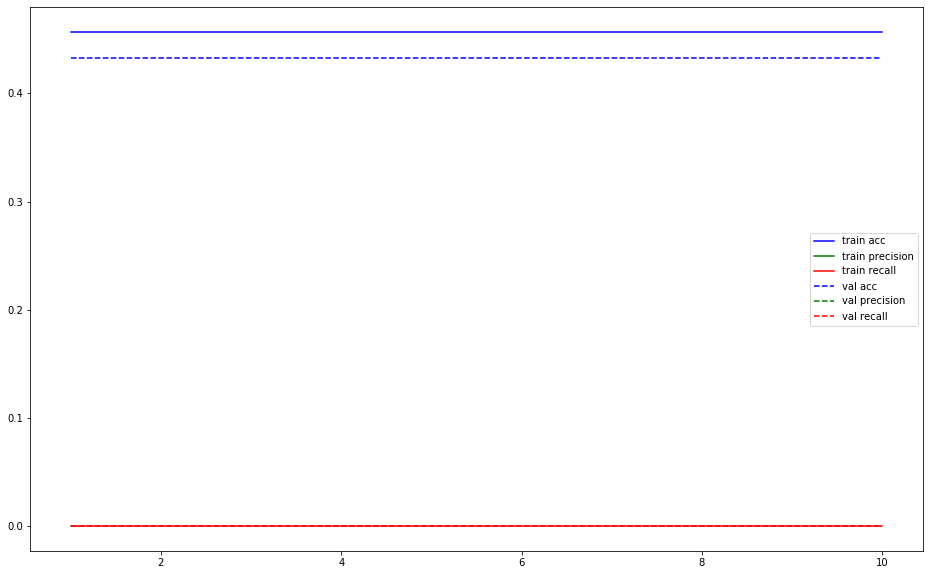

In [0]:
import json
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
#import cPickle as pickle
import pickle
import os
from datetime import datetime, timedelta
import pandas as pd

xrange=range
DATA_PATH_PIC = "/content/drive/My Drive/CS230 Stock Project/data/PIC/batch_size1_version1/"


class CNN():

    def __init__(self, sess):
        
        self.sess = sess
        self.epochs = 10
        self.batch_size =1

        self.l2_lambda = 1e-4
        self.lr = 1e-4

        self.d = 300
        self.l = 3

        self.max_mid_term = 7
        self.max_long_term = 30

        self.checkpoint_dir = '/content/drive/My Drive/CS230 Stock Project/checkpoints/'
        self.build_model()

    def build_model(self):
        #define input layers
        self.long_term_events = tf.placeholder(tf.float32, [self.batch_size, self.max_long_term, self.d], name='long_term_events')
        self.mid_term_events = tf.placeholder(tf.float32, [self.batch_size, self.max_mid_term, self.d], name='mid_term_events')
        self.short_term_events = tf.placeholder(tf.float32, [self.batch_size, None, self.d], name='short_term_events')
        
        #define output layers
        self.labels = tf.placeholder(tf.float32, [self.batch_size], name='labels')

        #define hidden layers/convolution layers
        self.long_term_conv = self.conv1d(self.long_term_events, output_dim=self.d, name='long_term_conv')
        self.mid_term_conv = self.conv1d(self.mid_term_events, output_dim=self.d, name='mid_term_conv')

        #define pooling layers
        self.long_term_pool = tf.reduce_max(self.long_term_conv, axis=2)
        
      
        self.mid_term_pool = tf.reduce_max(self.mid_term_conv, axis=2)
        self.short_term_pool = tf.reduce_mean(self.short_term_events, axis=1)

        #concatenate long_term, mid_term, and short_term pool into one tensor along the num_event axis 1
        self.v = tf.concat([self.long_term_pool, self.mid_term_pool, self.short_term_pool], axis=1)
 
        #fully connected hidden layers with 100 variables
        self.y = tf.layers.dense(self.v, 100, activation=tf.nn.sigmoid)
        # print self.y.shape

        #output layer
        self.logits = tf.reshape(tf.layers.dense(self.y, 1, activation=tf.nn.sigmoid), [self.batch_size], name='preds')
        # print self.logits.shape

        # print tf.trainable_variables()
        
        # ce_loss: regular old cross entropy loss; l2_loss: minimize square errors
        self.ce_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.logits)
        self.l2_loss = sum([tf.reduce_sum(tf.square(var)) for var in tf.trainable_variables()])

        self.loss = self.ce_loss + (self.l2_lambda * self.l2_loss)

        self.saver = tf.train.Saver()

    # Yitian: Sanity check of params
    # param input: the input layer
    # param output_dim: the number of filters to use
    # param k_w: kernel width
    # param d_w: stride 
    def conv1d(self, input, output_dim=1, k_w=3, d_w=1, stddev=0.02, name='conv1d'):
        
        
        with tf.variable_scope(name):

            w = tf.get_variable('w', [k_w, input.get_shape()[-1], output_dim],
                                initializer=tf.truncated_normal_initializer(stddev=stddev))
            conv = tf.nn.conv1d(input, w, stride=d_w, padding='SAME')

            biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
            conv = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))
            #what does tf.reshape here do? Seems redundant
            return conv


    def train(self, data, val_data):
        cnn_optim = tf.train.AdamOptimizer(self.lr).minimize(self.loss, var_list=tf.trainable_variables())

        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        counter = 0
        start_time = time.time()

        losses = []
        ce_losses = []
        l2_losses = []
        tps = []
        fps = []
        tns = []
        fns = []

        for epoch in xrange(self.epochs):
            length = len(data)
            batch_idxs = length // self.batch_size

            batch_loss = 0
            batch_ce_loss = 0
            batch_l2_loss = 0
            batch_per_error = 0
            batch_tp = 0
            batch_fp = 0
            batch_tn = 0
            batch_fn = 0

            for idx in xrange(0, batch_idxs):
                batch_data = data[idx*self.batch_size:(idx+1)*self.batch_size]
                print(np.shape(np.array(batch_data)[:,0]))

                feed_dict = {   
                         
                                self.short_term_events: np.array([batch_data[0][0].reshape([self.batch_size, self.d])]),
                                self.mid_term_events: np.array([batch_data[0][1]]),
                                self.long_term_events: np.array([batch_data[0][2]]),
                                self.labels: np.array(batch_data[0][3].reshape([self.batch_size]))
                            }
                ##batch_size>1
              #  feed_dict = {   
                         
              #                   #self.short_term_events: np.array([batch_data[:][0].reshape([self.batch_size, self.d])]),
              #                   self.short_term_events: np.array(batch_data)[:,0],
              #                   self.mid_term_events: np.array(batch_data)[:,1],
              #                   self.long_term_events: np.array(batch_data)[:,2],
              #                   #self.labels: np.array(batch_data[:][3].reshape([self.batch_size]))
              #                   self.labels: np.array(batch_data)[:,3]
              #               }
                
                # if idx == 0:
                #     print feed_dict[self.corrupt]
                
                #print(feed_dict)
                vlist = tf.trainable_variables()
                vnames = [v.name for v in vlist]
                
                # print vnames
                __ = self.sess.run([cnn_optim, self.logits] + vlist, feed_dict=feed_dict)
                
                _ = __[0]
                logits = __[1]
                label = batch_data[0][3]
                print(label)
                ce_loss = self.ce_loss.eval(feed_dict)
                l2_loss = self.l2_loss.eval(feed_dict)
                loss = self.loss.eval(feed_dict)

                # print loss, u_loss, l2_loss
                batch_loss += loss
                batch_ce_loss += ce_loss
                batch_l2_loss += l2_loss
                if label == 1 and logits > .5:
                    batch_tp += 1.0
                if label == 0 and logits > .5:
                    batch_fp += 1.0
                if label == 0 and logits <= .5:
                    batch_tn += 1.0
                if label == 1 and logits <= .5:
                    batch_fn += 1.0
                
                
                counter += 1
                print('Train Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.8f, ce_loss: %.8f, l2_loss: %.8f' \
                    % (epoch, idx, batch_idxs,
                        time.time() - start_time, loss, ce_loss, l2_loss))

                if np.mod(counter, 1000) == 1:
                    print (logits, feed_dict[self.labels])

            batch_loss /= batch_idxs
            batch_ce_loss /= batch_idxs
            batch_l2_loss /= batch_idxs
            losses += [[batch_loss[0]]]
            ce_losses += [[batch_ce_loss[0]]]
            l2_losses += [[self.l2_lambda * batch_l2_loss]]
            tps += [[batch_tp]]
            fps += [[batch_fp]]
            tns += [[batch_tn]]
            fns += [[batch_fn]]
            # print losses

# -------------------VALIDATION----------------------

            # val_length = min(len(val_data), self.val_size)
            val_length = len(val_data)
            val_batch_idxs = val_length // self.batch_size

            batch_loss = 0
            batch_ce_loss = 0
            batch_l2_loss = 0
            batch_per_error = 0
            batch_tp = 0
            batch_fp = 0
            batch_tn = 0
            batch_fn = 0

            for idx in xrange(0, val_batch_idxs):
                batch_data = val_data[idx*self.batch_size:(idx+1)*self.batch_size]
                feed_dict = {   
                         
                                self.short_term_events: np.array([batch_data[0][0].reshape([self.batch_size, self.d])]),
                                self.mid_term_events: np.array([batch_data[0][1]]),
                                self.long_term_events: np.array([batch_data[0][2]]),
                                self.labels: np.array(batch_data[0][3].reshape([self.batch_size]))
                            }
                ##batch_size>1
                # feed_dict = {   
                         
                #                 #self.short_term_events: np.array([batch_data[:][0].reshape([self.batch_size, self.d])]),
                #                 self.short_term_events: np.array([batch_data[:][0]]),
                #                 self.mid_term_events: np.array([batch_data[:][1]]),
                #                 self.long_term_events: np.array([batch_data[:][2]]),
                #                 #self.labels: np.array(batch_data[:][3].reshape([self.batch_size]))
                #                 self.labels: np.array(batch_data[:][3])
                #             }
                
                
                ce_loss = self.ce_loss.eval(feed_dict)
                
                l2_loss = self.l2_loss.eval(feed_dict)
                loss = self.loss.eval(feed_dict)
                logits = self.logits.eval(feed_dict)

                label = batch_data[0][3]
                
                # print loss, u_loss, l2_loss
                batch_loss += loss
                batch_ce_loss += ce_loss
                batch_l2_loss += l2_loss
                # if label[0] == 1 and logits > .5:
                #     batch_tp += 1.0
                # if label[0] == 0 and logits > .5:
                #     batch_fp += 1.0
                # if label[0] == 0 and logits <= .5:
                #     batch_tn += 1.0
                # if label[0] == 1 and logits <= .5:
                #     batch_fn += 1.0
                if label== 1 and logits > .5:
                    batch_tp += 1.0
                if label == 0 and logits > .5:
                    batch_fp += 1.0
                if label == 0 and logits <= .5:
                    batch_tn += 1.0
                if label == 1 and logits <= .5:
                    batch_fn += 1.0
                

                print('Val Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.8f, ce_loss: %.8f, l2_loss: %.8f' \
                    % (epoch, idx, val_batch_idxs,
                        time.time() - start_time, loss, ce_loss, l2_loss))

            batch_loss /= val_batch_idxs
            batch_ce_loss /= val_batch_idxs
            batch_l2_loss /= val_batch_idxs
            losses[-1] += [batch_loss[0]]
            ce_losses[-1] += [batch_ce_loss[0]]
            l2_losses[-1] += [self.l2_lambda * batch_l2_loss]
            tps[-1] += [batch_tp]
            fps[-1] += [batch_fp]
            tns[-1] += [batch_tn]
            fns[-1] += [batch_fn]

            losses_arr = np.array(losses)
            ce_losses_arr = np.array(ce_losses)
            l2_losses_arr = np.array(l2_losses)

            tps_arr = np.array(tps)
            fps_arr = np.array(fps)
            tns_arr = np.array(tns)
            fns_arr = np.array(fns)

            # print losses_arr.shape, losses_arr[:,0].shape, losses_arr[:,0]

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(losses_arr))], losses_arr[:,0], label='total loss', color='b')
            plt.plot([i+1 for i in range(len(ce_losses_arr))], ce_losses_arr[:,0], label='ce loss', color='g')
            plt.plot([i+1 for i in range(len(l2_losses_arr))], l2_losses_arr[:,0], label='l2 loss', color='r')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'trn_losses.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(tps_arr))], tps_arr[:,0], label='tp', color='b')
            plt.plot([i+1 for i in range(len(fps_arr))], fps_arr[:,0], label='fp', color='g')
            plt.plot([i+1 for i in range(len(tns_arr))], tns_arr[:,0], label='tn', color='r')
            plt.plot([i+1 for i in range(len(fns_arr))], fns_arr[:,0], label='fn', color='c')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'trn_pns.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide((tps_arr+tns_arr)[:,0], (tps_arr+tns_arr+fps_arr+fns_arr)[:,0]), label='acc', color='b')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,0], (tps_arr+fps_arr)[:,0]), label='precision', color='g')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,0], (tps_arr+fns_arr)[:,0]), label='recall', color='r')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'trn_acc.png')


            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(losses_arr))], losses_arr[:,1], label='total loss', color='b')
            plt.plot([i+1 for i in range(len(ce_losses_arr))], ce_losses_arr[:,1], label='ce loss', color='g')
            plt.plot([i+1 for i in range(len(l2_losses_arr))], l2_losses_arr[:,1], label='l2 loss', color='r')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'val_losses.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(tps_arr))], tps_arr[:,1], label='tp', color='b')
            plt.plot([i+1 for i in range(len(fps_arr))], fps_arr[:,1], label='fp', color='g')
            plt.plot([i+1 for i in range(len(tns_arr))], tns_arr[:,1], label='tn', color='r')
            plt.plot([i+1 for i in range(len(fns_arr))], fns_arr[:,1], label='fn', color='c')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'val_pns.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide((tps_arr+tns_arr)[:,1], (tps_arr+tns_arr+fps_arr+fns_arr)[:,1]), label='acc', color='b')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,1], (tps_arr+fps_arr)[:,1]), label='precision', color='g')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,1], (tps_arr+fns_arr)[:,1]), label='recall', color='r')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'val_acc.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(losses_arr))], losses_arr[:,0], label='train total loss', color='b')
            plt.plot([i+1 for i in range(len(ce_losses_arr))], ce_losses_arr[:,0], label='train ce loss', color='g')
            plt.plot([i+1 for i in range(len(l2_losses_arr))], l2_losses_arr[:,0], label='train l2 loss', color='r')
            plt.plot([i+1 for i in range(len(losses_arr))], losses_arr[:,1], label='val total loss', linestyle='--', color='b')
            plt.plot([i+1 for i in range(len(ce_losses_arr))], ce_losses_arr[:,1], label='val ce loss', linestyle='--', color='g')
            plt.plot([i+1 for i in range(len(l2_losses_arr))], l2_losses_arr[:,1], label='val l2 loss', linestyle='--', color='r')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'losses.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(tps_arr))], tps_arr[:,0], label='train tp', color='b')
            plt.plot([i+1 for i in range(len(fps_arr))], fps_arr[:,0], label='train fp', color='g')
            plt.plot([i+1 for i in range(len(tns_arr))], tns_arr[:,0], label='train tn', color='r')
            plt.plot([i+1 for i in range(len(fns_arr))], fns_arr[:,0], label='train fn', color='c')
            plt.plot([i+1 for i in range(len(tps_arr))], tps_arr[:,1], label='val tp', linestyle='--', color='b')
            plt.plot([i+1 for i in range(len(fps_arr))], fps_arr[:,1], label='val fp', linestyle='--', color='g')
            plt.plot([i+1 for i in range(len(tns_arr))], tns_arr[:,1], label='val tn', linestyle='--', color='r')
            plt.plot([i+1 for i in range(len(fns_arr))], fns_arr[:,1], label='val fn', linestyle='--', color='c')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'pns.png')

            plt.figure(figsize=(16,10))
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide((tps_arr+tns_arr)[:,0], (tps_arr+tns_arr+fps_arr+fns_arr)[:,0]), label='train acc', color='b')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,0], (tps_arr+fps_arr)[:,0]), label='train precision', color='g')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,0], (tps_arr+fns_arr)[:,0]), label='train recall', color='r')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide((tps_arr+tns_arr)[:,1], (tps_arr+tns_arr+fps_arr+fns_arr)[:,1]), label='val acc', linestyle='--', color='b')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,1], (tps_arr+fps_arr)[:,1]), label='val precision', linestyle='--', color='g')
            plt.plot([i+1 for i in range(len(tps_arr))], np.divide(tps_arr[:,1], (tps_arr+fns_arr)[:,1]), label='val recall', linestyle='--', color='r')
            plt.legend()
            plt.savefig(DATA_PATH_PIC+'acc.png')



def main(_):
    SP500_movement_direction = pd.read_pickle(DATA_PATH + "/SP500_movement_direction.pkl")
    all_data = pd.read_pickle(DATA_PATH + "/ave_vec.pkl")
    real_time=set(SP500_movement_direction['time'])
    del_list=[]
    for i in range(len(all_data['time'])):
      if not all_data['time'][i] in real_time:
        del_list.append(i)

    data=all_data.drop(del_list)
    data=data.reset_index(drop=True)

    training_dataset={} #a dictionary, key: date, value: training value
    val_dataset={}
    lt_days=30
    mt_days=7
    for i in range(lt_days,1407):
      # lt=np.array(data['ave_vec'][i-lt_days:i] for j in range(i-lt_days:i))
      # mt=np.array(data['ave_vec'][i-mt_days:i])
      # st=np.array(data['ave_vec'][i-1]).reshape(1,300) 
      lt=data['ave_vec'][i-lt_days:i]
      mt=data['ave_vec'][i-mt_days:i]
      st=data['ave_vec'][i-1]
      label=SP500_movement_direction['GSPC.Adjusted'][i]
      training_dataset[data['time'][i]]=[st,mt,lt,label]
    for i in range(1407,len(data['time'])):
      lt=data['ave_vec'][i-lt_days:i]
      mt=data['ave_vec'][i-mt_days:i]
      st=data['ave_vec'][i-1]
      label=SP500_movement_direction['GSPC.Adjusted'][i]
      val_dataset[data['time'][i]]=[st,mt,lt,label]
    tf.reset_default_graph()
    with tf.Session() as sess:
          model = CNN(sess)

          model.train(list(training_dataset.values()), list(val_dataset.values()))

if __name__ == '__main__':
    tf.app.run()